In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Modules

In [2]:
import os
import re
import time
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score

from imblearn.metrics import geometric_mean_score

import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dialect/Language Bangla Merge All without Feni.csv')

In [4]:
df

,sentence,label
0,কেন আচো?,Chittagong
1,আযিয়া আর মন বালা নাই?,Chittagong
2,তুঁই কি গরো?,Chittagong
3,এই গরমত আত্তুন কিচু বালা ন লাগের,Chittagong
4,ফোয়াইবা সাদা রংওর উজ্ঞা শার্ট ফরি আইস্যিল,Chittagong
...,...,...
35151,তুমি যাও এইহান থাইক্কা,Mymensingh
35152,আফনে যান এইহান থাইক্কা,Mymensingh
35153,তুই যা এইহান থাইক্কা,Mymensingh
35154,আফনেরা পার্কে ঘুইরা বেড়ান,Mymensingh


In [5]:
!pip install sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 64.2 MB/s eta 0:00:00


                                             |          | [  0%]   00:00 -> (? left)

Report initial_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



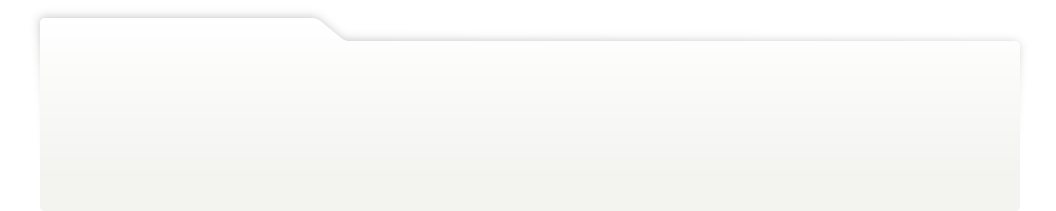
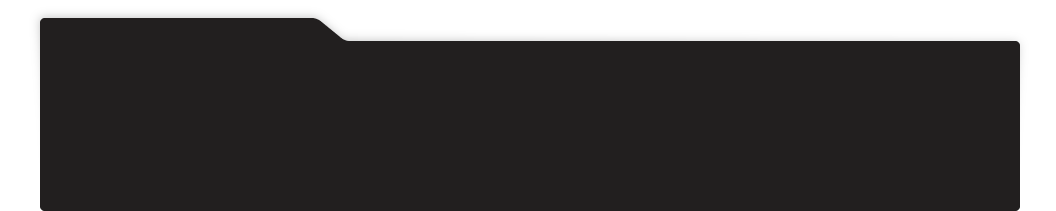
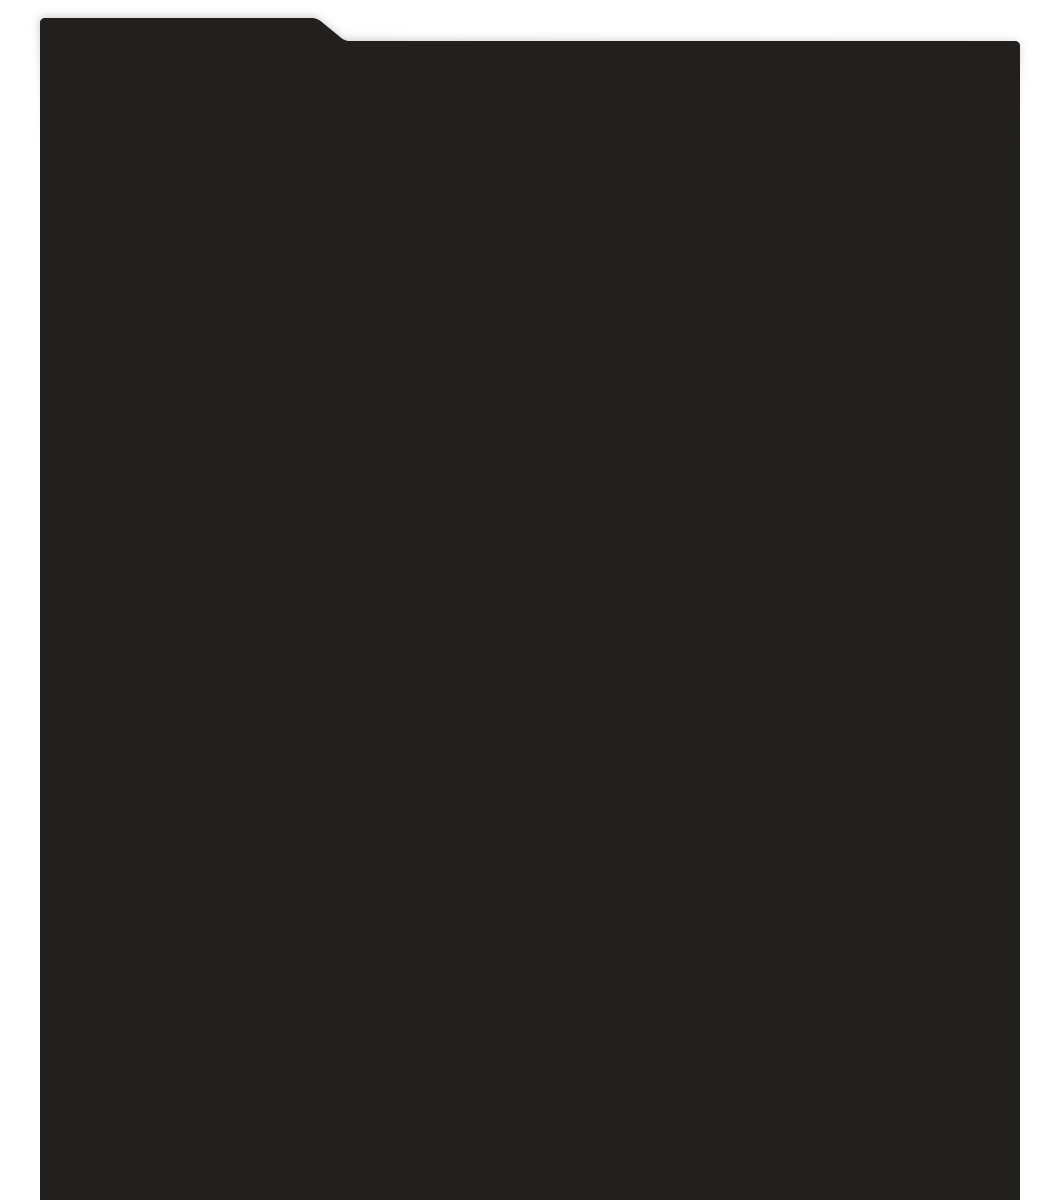
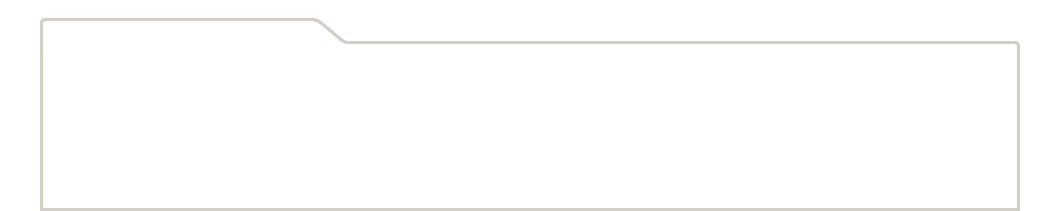
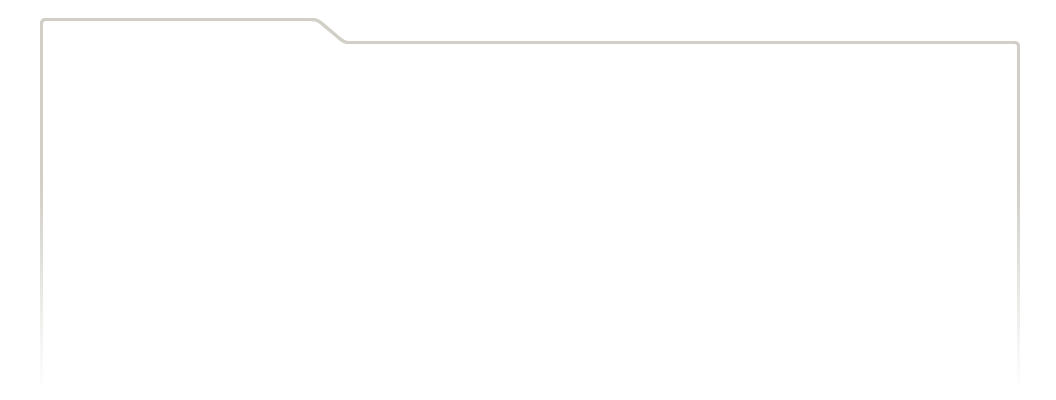
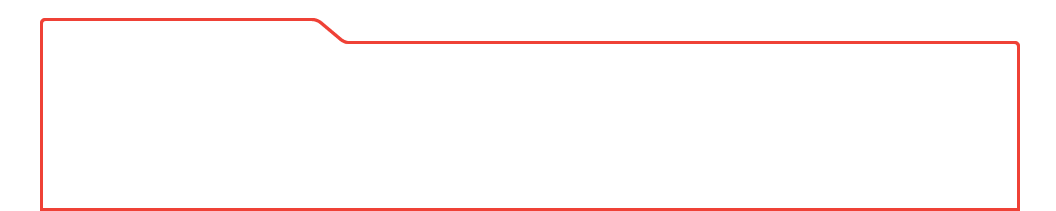
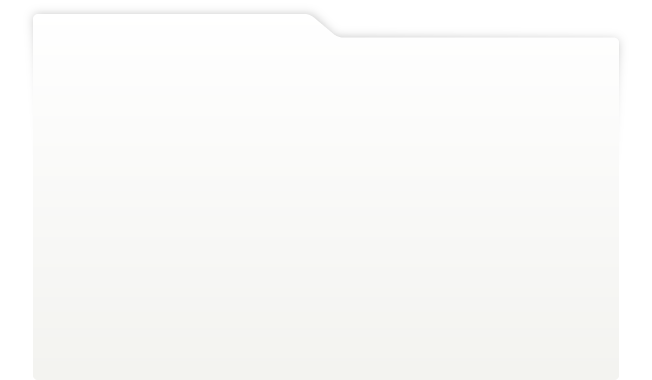
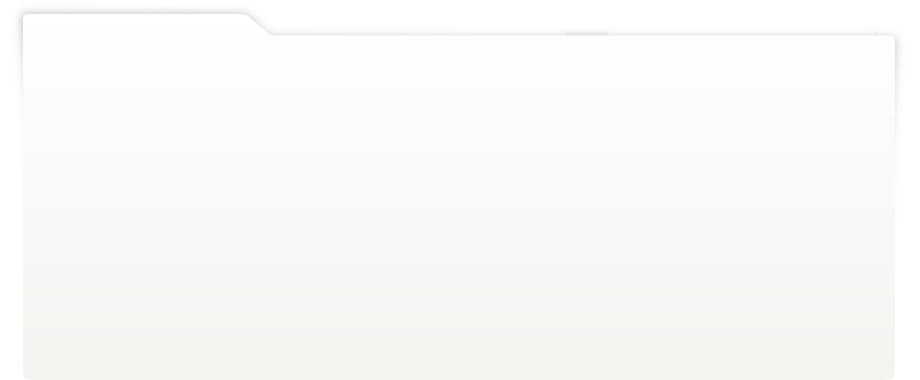
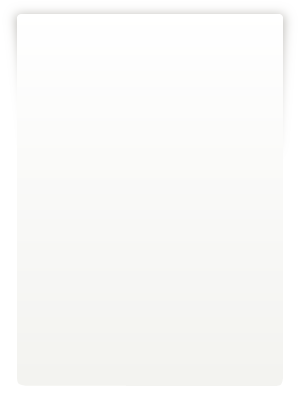
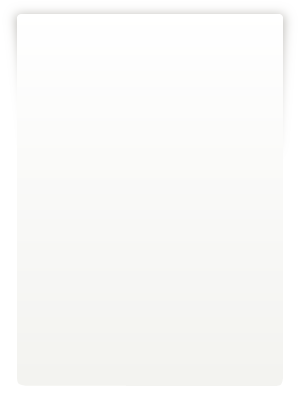
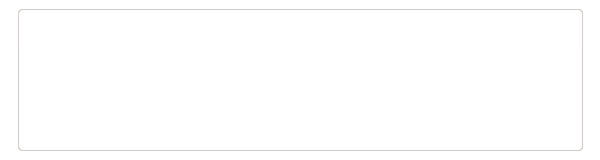
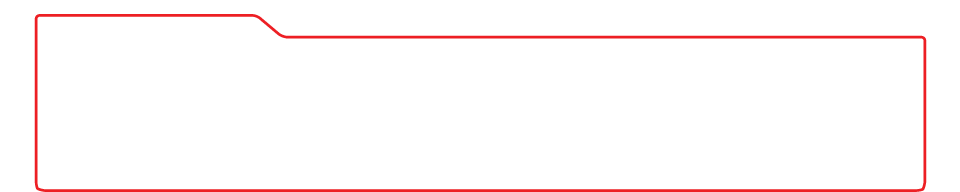
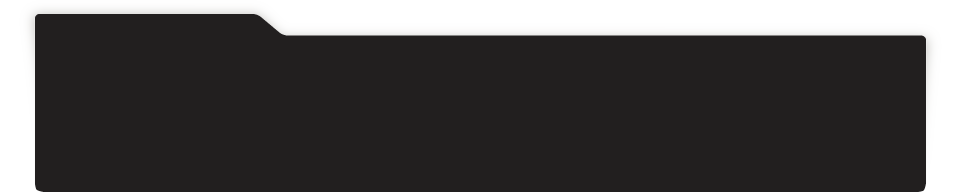
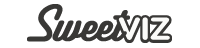
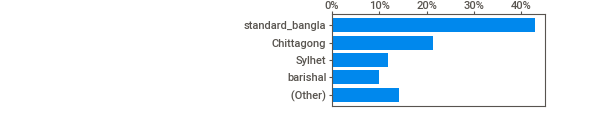
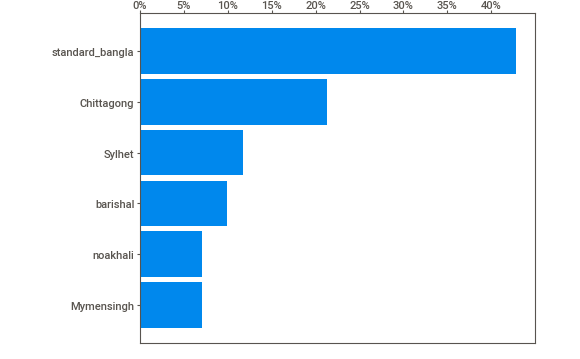
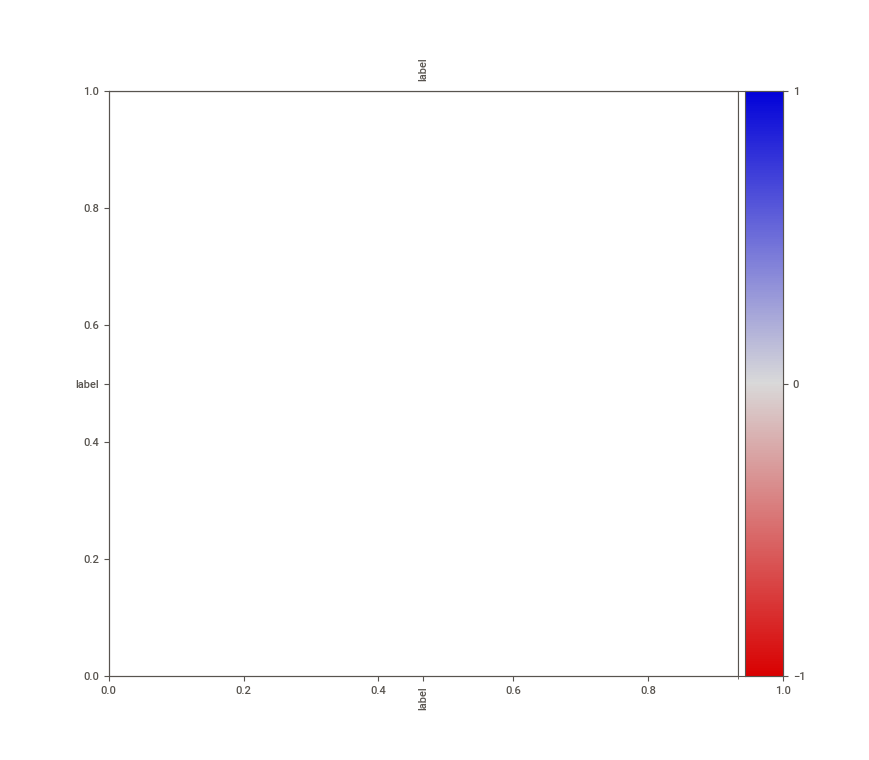
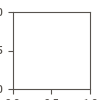

In [6]:
# EDA using sweetviz

import sweetviz as sv

report = sv.analyze(df)
report.show_html('initial_report.html')

import IPython
IPython.display.HTML(filename='/content/initial_report.html')

In [7]:
# remove missing values and show count

df.dropna(inplace=True)

df.isnull().sum()

,0
sentence,0
label,0


In [8]:
# remove duplicates keeping the first one and show count

df.drop_duplicates(subset=None, keep='first', inplace=True)

df.duplicated().sum()

0

In [9]:
# Label encoding

le_x  = LabelEncoder()

df['label'] = le_x.fit_transform(df.label)

label_mapping = dict(zip(le_x.classes_, le_x.transform(le_x.classes_)))
print(label_mapping)

{'Chittagong': 0, 'Mymensingh': 1, 'Sylhet': 2, 'barishal': 3, 'noakhali': 4, 'standard_bangla': 5}


                                             |          | [  0%]   00:00 -> (? left)

Report final_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



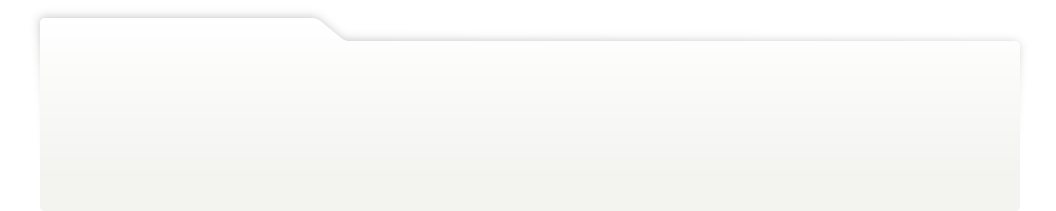
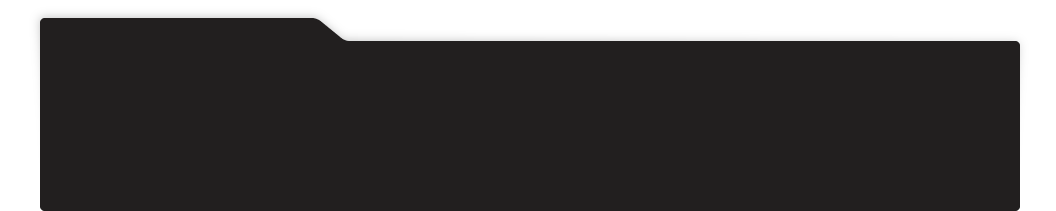
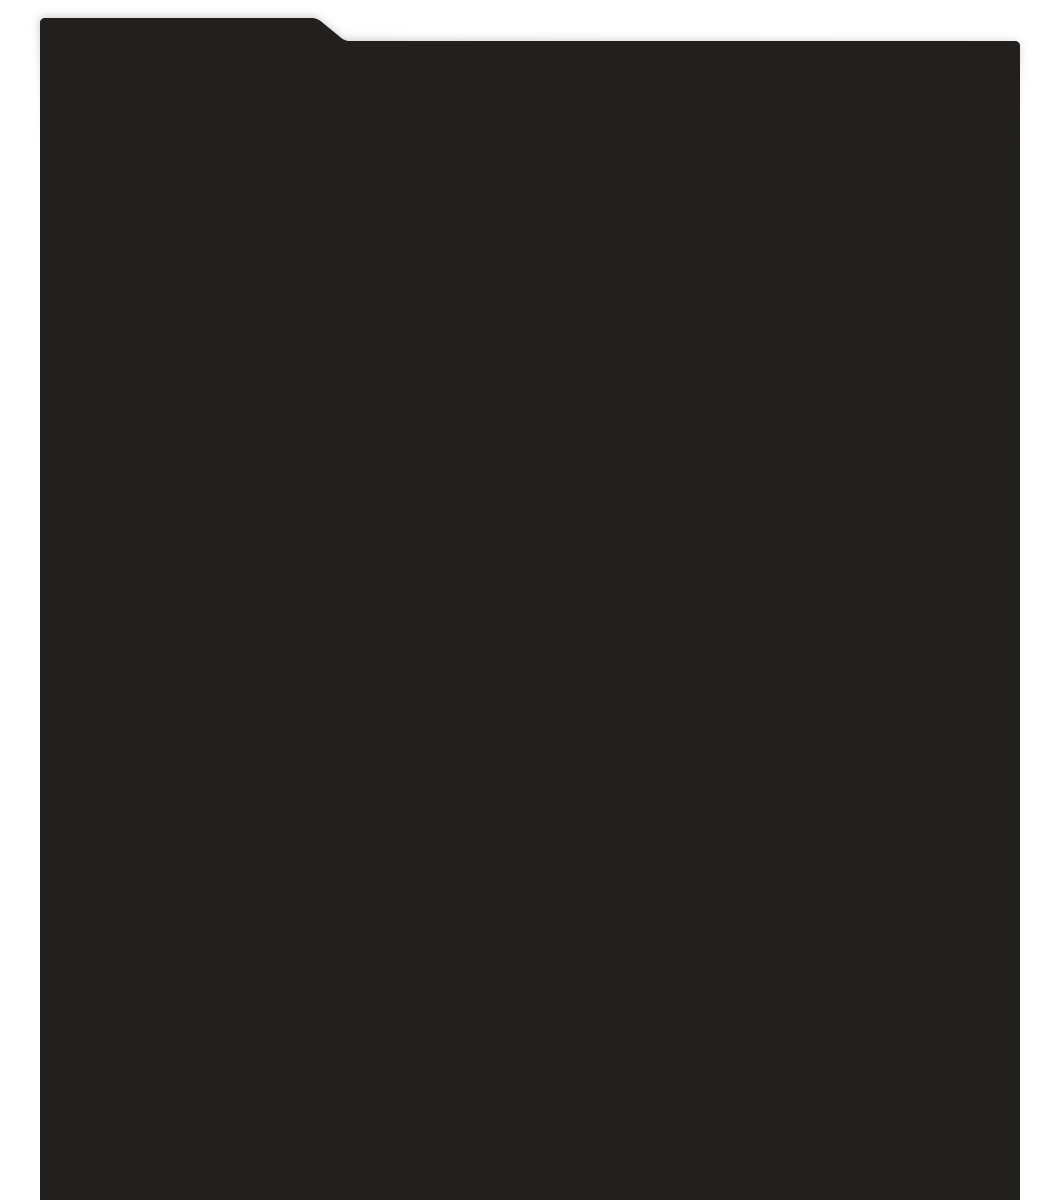
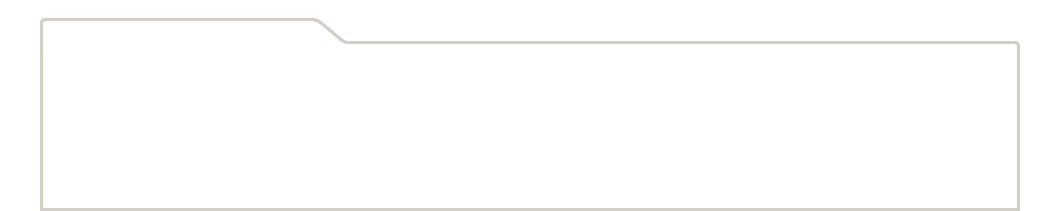
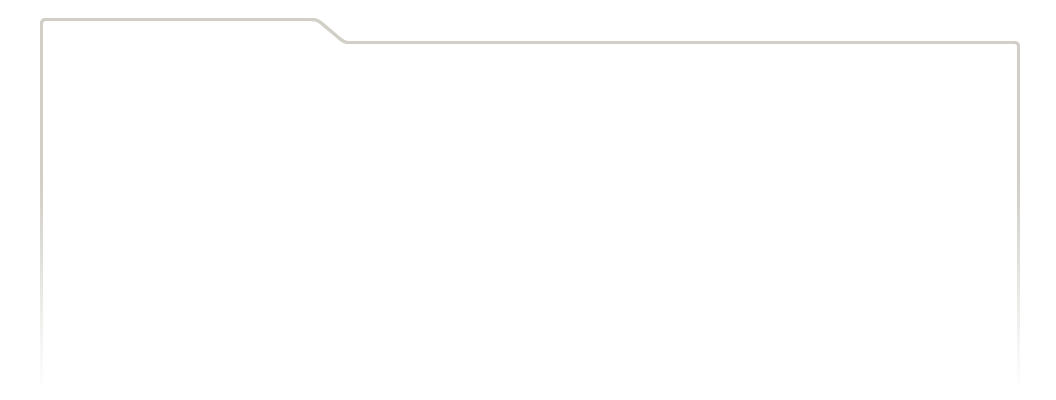
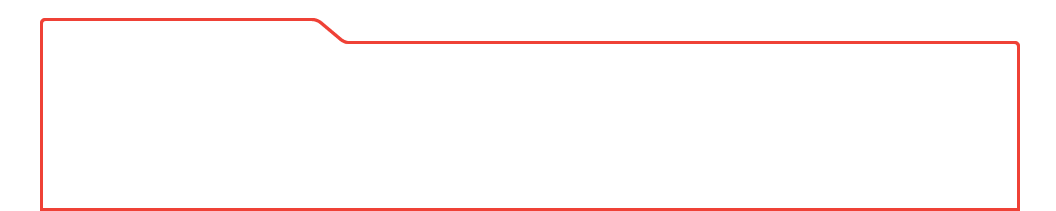
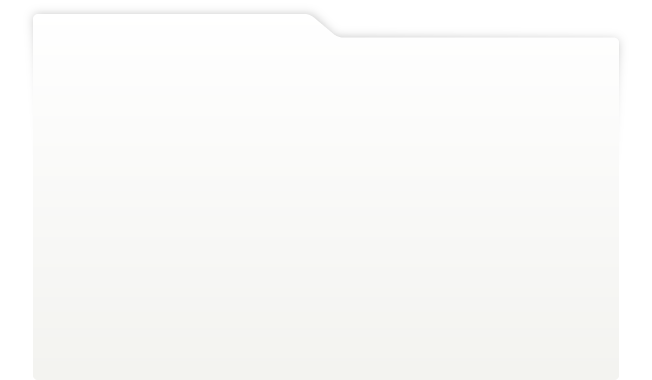
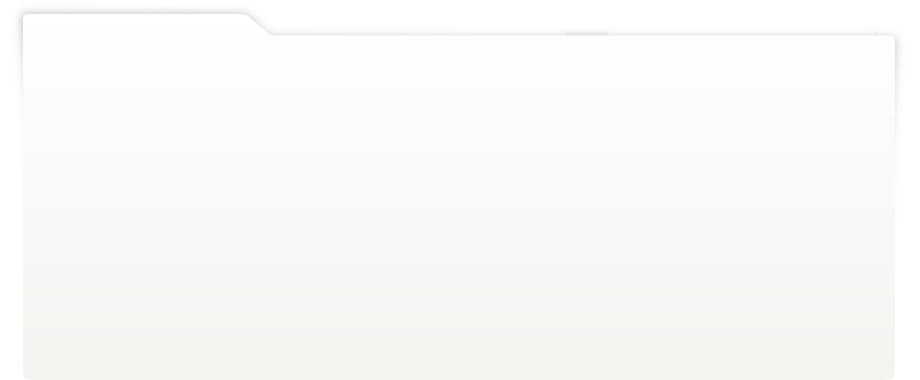
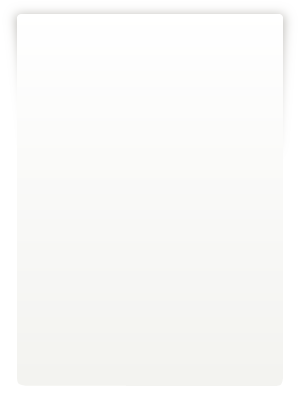
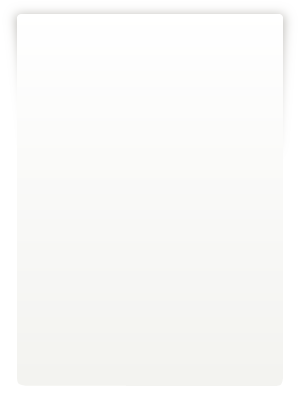
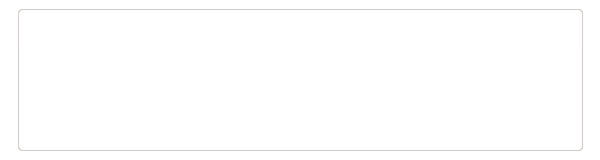
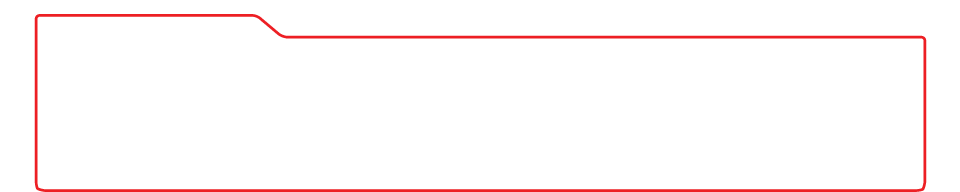
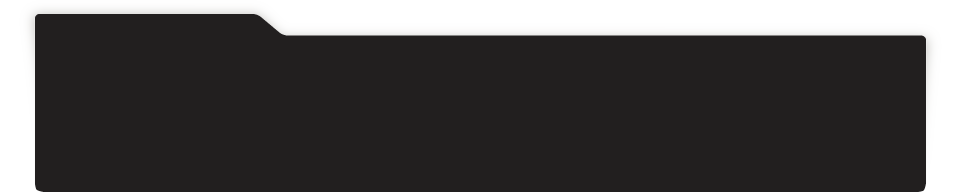
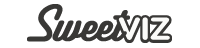
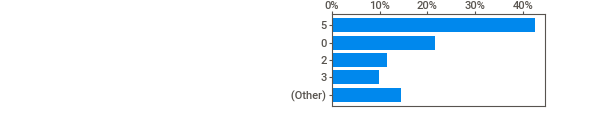
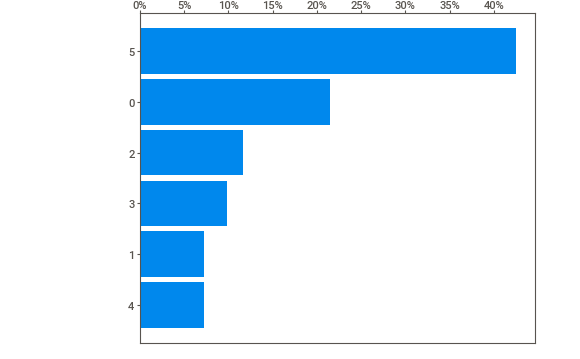
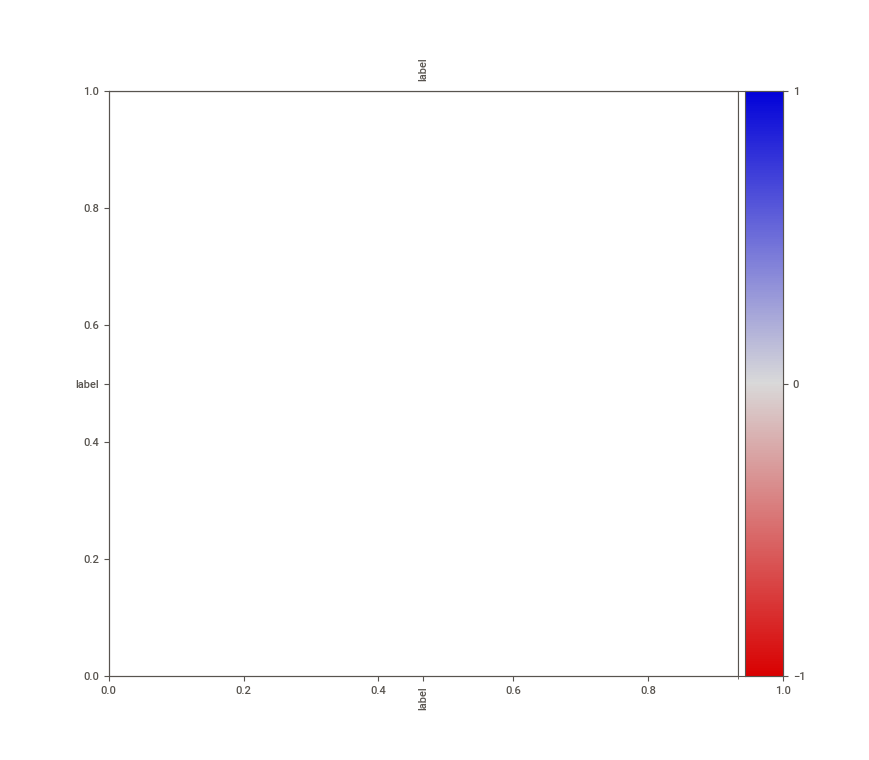
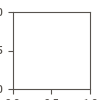

In [10]:
report = sv.analyze(df)
report.show_html('final_report.html')

import IPython
IPython.display.HTML(filename='/content/final_report.html')

In [11]:
df

,sentence,label
0,কেন আচো?,0
1,আযিয়া আর মন বালা নাই?,0
2,তুঁই কি গরো?,0
3,এই গরমত আত্তুন কিচু বালা ন লাগের,0
4,ফোয়াইবা সাদা রংওর উজ্ঞা শার্ট ফরি আইস্যিল,0
...,...,...
35151,তুমি যাও এইহান থাইক্কা,1
35152,আফনে যান এইহান থাইক্কা,1
35153,তুই যা এইহান থাইক্কা,1
35154,আফনেরা পার্কে ঘুইরা বেড়ান,1


# Model Training

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Helping functions

- Dataset Loader
- Save & Load Checkpoints
- Metrics calculation

In [13]:
# dataloader setup

class DialectDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item


def prepare_data(X_train, X_test, y_train, y_test, tokenizer, batch_size, max_length=None):
    train_encodings = tokenizer(list(X_train), padding=True, truncation=True)
    val_encodings = tokenizer(list(X_test), padding=True, truncation=True)

    train_dataset = DialectDataset(train_encodings, list(y_train))
    val_dataset = DialectDataset(val_encodings, list(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [14]:
# checkpoint saving with time tracking
def save_checkpoint(model, optimizer, epoch, all_metrics, total_time, full_path):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'all_metrics': all_metrics,
        'total_time': total_time
    }

    # base_dir = "/content/drive/MyDrive/Dialect/checkpoints"
    # os.makedirs(base_dir, exist_ok=True)
    # full_path = os.path.join(base_dir, filename)
    torch.save(checkpoint, full_path)


# checkpoint loading with time tracking
def load_checkpoint(model, optimizer, filename):
    if torch.cuda.is_available():
        checkpoint = torch.load(filename)
    else:
        checkpoint = torch.load(filename, map_location=torch.device('cpu'))

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    all_metrics = checkpoint['all_metrics']
    total_time = checkpoint['total_time']

    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}. Total time so far: {total_time:.2f} minutes.")
    return model, optimizer, start_epoch, all_metrics, total_time


In [15]:
# function to calculate PF score based on presion-f1_score (harmonic mean)
def pf_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    pf = 2 * (precision * f1) / (precision + f1) if (precision + f1) != 0 else 0
    return pf


# function to calculate all the metrics
def calculate_metrics(labels, preds, probs, loss):
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    g_mean = geometric_mean_score(labels, preds, average='weighted')
    auc = roc_auc_score(labels, probs, multi_class='ovr', average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    balanced_acc = balanced_accuracy_score(labels, preds)
    balanced_acc_loss = 1 - balanced_accuracy_score(labels, preds)
    pf = pf_score(labels, preds)

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'f1': f1,
        'g_mean': g_mean,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'balanced_acc': balanced_acc,
        'balanced_acc_loss': balanced_acc_loss,
        'pf': pf
    }

    return metrics

## Train/Test Loop

In [16]:
# Train function
def train(model, train_loader, optimizer, device, class_weights=None, criterion=torch.nn.CrossEntropyLoss()):
    model.train()
    preds, labels, probs = [], [], []

    total_loss = 0
    start_time = time.time()

    if class_weights is not None:
      criterion = criterion(weight=class_weights)

    for batch in tqdm(train_loader, desc='Training'):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        logits = outputs.logits
        labels_batch = batch['labels']

        loss = criterion(logits, labels_batch)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        labels.extend(labels_batch.tolist())
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        probs.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())

    end_time = time.time()
    avg_loss = total_loss / len(train_loader)
    train_time = (end_time - start_time) / 60

    metrics = calculate_metrics(labels, preds, probs, avg_loss)

    return train_time, metrics


# Evaluate function
def evaluate(model, val_loader, device, class_weights=None, criterion=torch.nn.CrossEntropyLoss()):
    model.eval()
    preds, labels, probs = [], [], []

    total_loss = 0
    start_time = time.time()

    if class_weights is not None:
      criterion = criterion(weight=class_weights)

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Evaluating'):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            logits = outputs.logits
            labels_batch = batch['labels']

            loss = criterion(logits, labels_batch)
            total_loss += loss.item()

            labels.extend(labels_batch.tolist())
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            probs.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())

    end_time = time.time()
    avg_loss = total_loss / len(val_loader)
    val_time = (end_time - start_time) / 60

    metrics = calculate_metrics(labels, preds, probs, avg_loss)

    return val_time, metrics,


In [17]:
# Main function to test each model
def test_model(train_data, test_data, train_label, test_label, model, tokenizer, epochs, batch_size, model_name=None, save_best_model=False, class_weights=None, criterion=None):
    train_loader, val_loader = prepare_data(train_data, test_data, train_label, test_label, tokenizer, batch_size)

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    print(f"Model will be trained on: {device}")

    path = '/content/drive/MyDrive/Dialect/checkpoints/'
    checkpoint_path = os.path.join(path, model_name + '-checkpoint.pth')
    best_model_path = os.path.join(path, model_name + '-best-model.pth')

    start_epoch = 1
    all_metrics = []
    total_time = 0

    # Initialize variable for tracking the best model
    best_val_accuracy = -float('inf')  # To track the best validation accuracy

    # Check training from scratch if checkpoint exists
    try:
        model, optimizer, start_epoch, all_metrics, total_time = load_checkpoint(model, optimizer, filename=checkpoint_path)
    except FileNotFoundError:
        print("Starting from scratch...")

    for epoch in range(start_epoch, epochs + 1):
        print(f'\n------ Epoch {epoch}/{epochs}')

        train_time, train_metrics = train(model, train_loader, optimizer, device, class_weights, criterion=criterion)
        val_time, val_metrics = evaluate(model, val_loader, device, class_weights, criterion=criterion)

        # Update total time
        total_time += train_time + val_time

        # Add current epoch metrics to all_metrics
        all_metrics.append({
            'epoch': epoch,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics
        })

        print(f'Train Loss: {train_metrics["loss"]:.3f} | Val Loss: {val_metrics["loss"]:.3f} | Train Acc: {train_metrics["accuracy"]:.3f} | Val Acc: {val_metrics["accuracy"]:.3f}')

        # Save checkpoint for each epoch
        save_checkpoint(model, optimizer, epoch, all_metrics, total_time, checkpoint_path)

        if save_best_model == True:
          # Check if this is the best model so far based on validation accuracy
          if val_metrics["accuracy"] > best_val_accuracy:
              best_val_accuracy = val_metrics["accuracy"]
              # Save the best model
              torch.save({
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()}, best_model_path)
              print(f"\nBest model saved at epoch {epoch} with Val Acc: {best_val_accuracy:.3f}")

    print(f"\nTraining & Validation completed. Total time: {total_time:.2f} minutes.")

    # print the final metrics after successful completion
    train_metrics = all_metrics[-1]['train_metrics']
    val_metrics = all_metrics[-1]['val_metrics']

    for phase, metrics in {"Training": train_metrics, "Validation": val_metrics}.items():
        print(f"\n{phase} Metrics:")
        for key, value in metrics.items():
            print(f"  {key.capitalize()}: {value:.3f}")

    if save_best_model == True:
      print("\n------ Best model saved !")


# Model Performance

Experiments are being done on Indic Bert. Might change it to some bigger model.

**Observations:**

- Better performance coming from heavy model
- Interrupted trainings have a sudden jump in validation

In [18]:
X = df['sentence']
y = df['label']

In [19]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Helping function

- Focal Loss function

- Metrics plotting


In [22]:
# Modified version of this implementation: https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py

class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)
            input = input.transpose(1, 2)
            input = input.contiguous().view(-1, input.size(2))
        target = target.view(-1, 1)

        logpt = torch.nn.functional.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            self.alpha = self.alpha.to(input.device)
            at = self.alpha.gather(0, target.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        return loss.mean() if self.size_average else loss.sum()

In [20]:
import matplotlib.pyplot as plt
import math

# Function to plot specified metrics from the checkpoint file
def plot_metrics_from_checkpoint(model_name, metrics_to_plot, checkpoint_file_path='/content/drive/MyDrive/Dialect/checkpoints/'):
    # Load checkpoint to access all_metrics
    checkpoint_path = os.path.join(checkpoint_file_path, model_name + '-checkpoint.pth')

    # Load the checkpoint and extract all metrics
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    all_metrics = checkpoint['all_metrics']

    # Initialize a dictionary to hold data for each metric
    metric_data = {metric: [] for metric in metrics_to_plot}

    # Extract the values from all_metrics for the selected metrics
    for epoch_metrics in all_metrics:
        for metric in metrics_to_plot:
            metric_data[metric].append(epoch_metrics['train_metrics'].get(metric, None))
            metric_data[metric].append(epoch_metrics['val_metrics'].get(metric, None))

    # Number of subplots (metrics to plot)
    num_plots = len(metrics_to_plot)

    # Calculate grid size (rows, columns)
    rows = math.ceil(num_plots / 3)
    cols = 3

    # Create a figure for plotting
    plt.figure(figsize=(12, 4 * rows))

    # Plot each metric requested
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(rows, cols, i + 1)

        epochs = range(1, len(all_metrics) + 1)

        # Separate train and validation values for this metric
        train_metric_values = metric_data[metric][::2]
        val_metric_values = metric_data[metric][1::2]

        # Plotting the metric for both training and validation
        plt.plot(epochs, train_metric_values, label=f'Training', color='blue')
        plt.plot(epochs, val_metric_values, label=f'Validation', color='red')

        plt.title(f'{metric.capitalize()} ({model_name})')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


## XLM-Roberta

- Raw data - 97%/96% (Recheck)

- **TODO:** Raw normalized data (Take normalizer from Bangla-BERT)

In [ ]:
# XLM-Roberta
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

xlm_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
xlm_roberta_base = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=6)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# raw data

xlm_raw = test_model(
    X_train,
    X_test,
    y_train,
    y_test,
    xlm_roberta_base,
    xlm_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='xlm-roberta-raw'
)

Model will be trained on: cuda
Checkpoint loaded. Resuming from epoch 13. Total time so far: 66.79 minutes.

------ Epoch 13/15


Evaluating: 100%|██████████| 216/216 [00:21<00:00, 10.00it/s]


Train Loss: 0.118 | Val Loss: 0.082 | Train Acc: 0.963 | Val Acc: 0.972

------ Epoch 14/15


Evaluating: 100%|██████████| 216/216 [00:21<00:00, 10.00it/s]


Train Loss: 0.093 | Val Loss: 0.100 | Train Acc: 0.969 | Val Acc: 0.964

------ Epoch 15/15


Evaluating: 100%|██████████| 216/216 [00:21<00:00, 10.01it/s]


Train Loss: 0.083 | Val Loss: 0.099 | Train Acc: 0.973 | Val Acc: 0.965

Training & Validation completed. Total time: 82.14 minutes.

Training Metrics:
  Loss: 0.083
  Accuracy: 0.973
  F1: 0.973
  G_mean: 0.982
  Auc: 0.999
  Precision: 0.973
  Recall: 0.973
  Balanced_acc: 0.959
  Balanced_acc_loss: 0.041
  Pf: 0.973

Validation Metrics:
  Loss: 0.099
  Accuracy: 0.965
  F1: 0.965
  G_mean: 0.978
  Auc: 0.999
  Precision: 0.965
  Recall: 0.965
  Balanced_acc: 0.953
  Balanced_acc_loss: 0.047
  Pf: 0.965


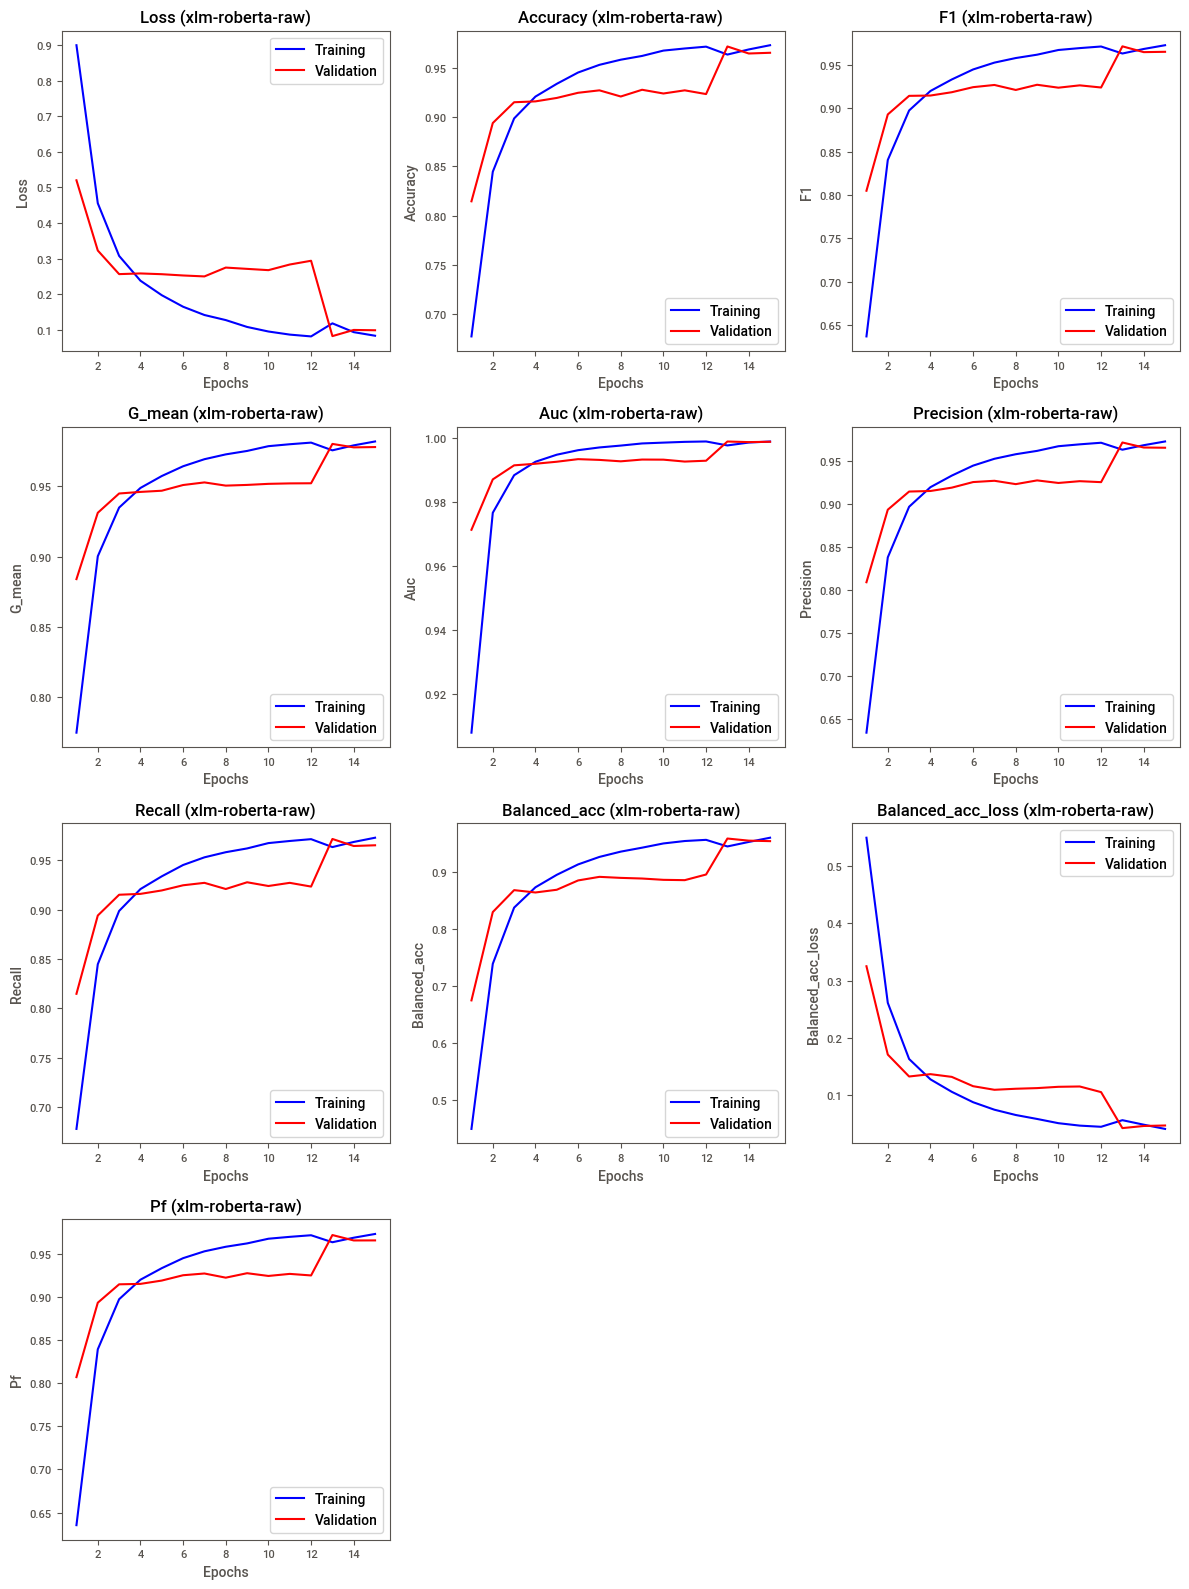

In [ ]:
# plot loss and training curve

plot_metrics_from_checkpoint(
    model_name='xlm-roberta-raw',
    metrics_to_plot=['loss', 'accuracy', 'f1', 'g_mean', 'auc', 'precision', 'recall', 'balanced_acc', 'balanced_acc_loss', 'pf']
)

In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer

In [ ]:
# raw data
from normalizer import normalize

mbert_raw = test_model(
    X_train.apply(normalize),
    X_test.apply(normalize),
    y_train,
    y_test,
    mbert_base,
    mb_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='xlm-roberta-raw-norm')

In [ ]:
# plot loss and training curve

plot_metrics_from_checkpoint(
    model_name='xlm-roberta-raw-norm',
    metrics_to_plot=['loss', 'accuracy', 'f1', 'g_mean', 'auc', 'precision', 'recall', 'balanced_acc', 'balanced_acc_loss', 'pf']
)

## mBERT

- **TODO:** Raw data -

- **TODO:** Raw normalized data (Take normalizer from Bangla-BERT)

In [ ]:
# mBERT
from transformers import BertTokenizer, BertForSequenceClassification

mb_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
mbert_base = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=6)

In [ ]:
# raw data

mbert_raw = test_model(
    X_train,
    X_test,
    y_train,
    y_test,
    mbert_base,
    mb_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='mbert-raw')

In [ ]:
# plot loss and training curve

plot_metrics_from_checkpoint(
    model_name='mbert-raw',
    metrics_to_plot=['loss', 'accuracy', 'f1', 'g_mean', 'auc', 'precision', 'recall', 'balanced_acc', 'balanced_acc_loss', 'pf']
)

In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer

In [ ]:
# raw data
from normalizer import normalize

mbert_raw = test_model(
    X_train.apply(normalize),
    X_test.apply(normalize),
    y_train,
    y_test,
    mbert_base,
    mb_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='mbert-raw-norm')

In [ ]:
# plot loss and training curve

plot_metrics_from_checkpoint(
    model_name='mbert-raw-norm',
    metrics_to_plot=['loss', 'accuracy', 'f1', 'g_mean', 'auc', 'precision', 'recall', 'balanced_acc', 'balanced_acc_loss', 'pf']
)

## BanglaBERT

- Raw normalized data - 96% (Recheck)

In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer

In [ ]:
# Bangla-BERT
from transformers import AutoModelForSequenceClassification, AutoTokenizer

bangla_bert_tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")
bangla_bert =AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglabert", num_labels=6)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# raw data
from normalizer import normalize

bangla_bert_raw = test_model(
    X_train.apply(normalize),
    X_test.apply(normalize),
    y_train,
    y_test,
    bangla_bert,
    bangla_bert_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='bangla-bert-raw'
)

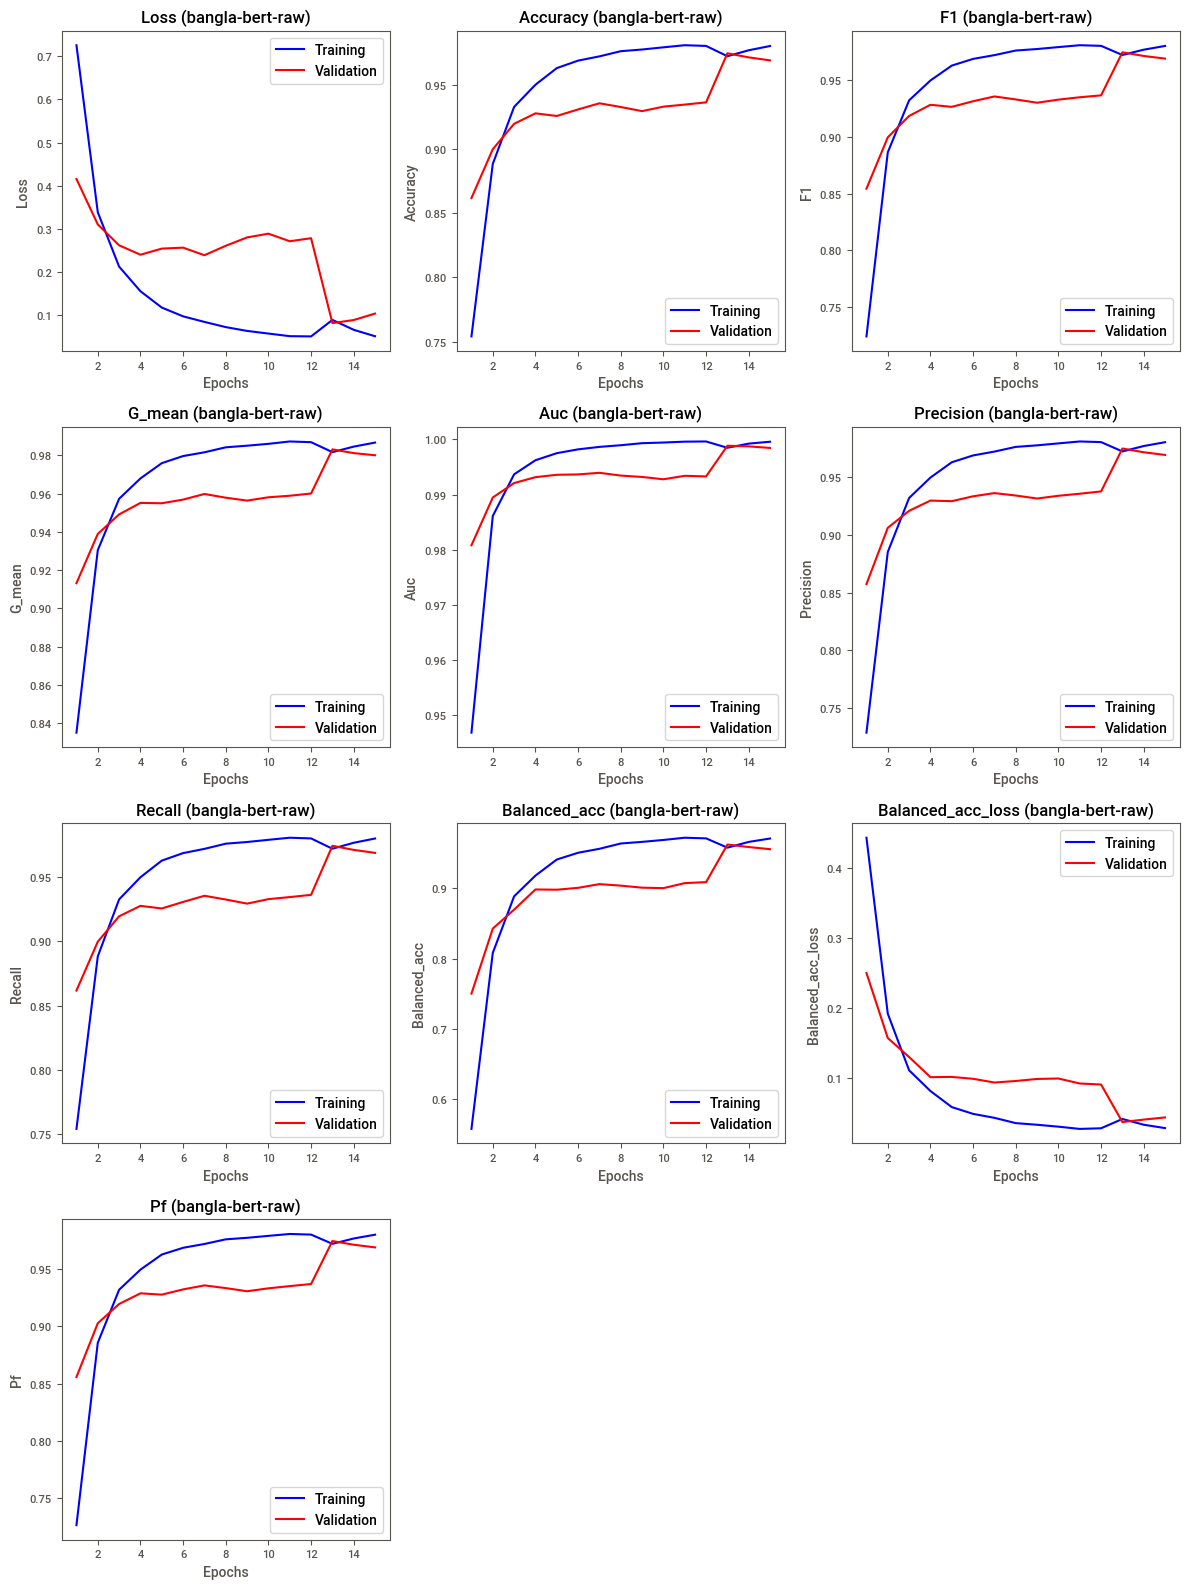

In [ ]:
# plot loss and training curve

plot_metrics_from_checkpoint(
    model_name='bangla-bert-raw',
    metrics_to_plot=['loss', 'accuracy', 'f1', 'g_mean', 'auc', 'precision', 'recall', 'balanced_acc', 'balanced_acc_loss', 'pf']
)

## IndicBert

- Raw data - 97%/90%

- Raw normalized data - 98%/88%

- Using class weights - 98%/88%

- Using sampling (Random over sampling) - 98%/88%

- Using focal loss with class weights (alpha value) - 98%/88%

- Using focal loss with class weights (alpha value) w Sampling (ROS) -

In [21]:
# Indic-BERT
from transformers import AutoModelForSequenceClassification, AutoTokenizer

indic_bert_tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert', keep_accents=True)
indic_bert = AutoModelForSequenceClassification.from_pretrained('ai4bharat/indic-bert', num_labels=6)

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Raw data

In [ ]:
# raw data

indic_bert_raw = test_model(
    X_train,
    X_test,
    y_train,
    y_test,
    indic_bert,
    indic_bert_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='indic-bert-raw')

Model will be trained on: cuda
Starting from scratch...

------ Epoch 1/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.69it/s]


Train Loss: 0.865 | Val Loss: 0.747 | Train Acc: 0.681 | Val Acc: 0.727
Best model saved at epoch 1 with Val Acc: 0.727

------ Epoch 2/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.86it/s]


Train Loss: 0.560 | Val Loss: 0.568 | Train Acc: 0.809 | Val Acc: 0.808
Best model saved at epoch 2 with Val Acc: 0.808

------ Epoch 3/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.80it/s]


Train Loss: 0.364 | Val Loss: 0.432 | Train Acc: 0.881 | Val Acc: 0.864
Best model saved at epoch 3 with Val Acc: 0.864

------ Epoch 4/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.89it/s]


Train Loss: 0.251 | Val Loss: 0.413 | Train Acc: 0.919 | Val Acc: 0.876
Best model saved at epoch 4 with Val Acc: 0.876

------ Epoch 5/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.87it/s]


Train Loss: 0.182 | Val Loss: 0.392 | Train Acc: 0.943 | Val Acc: 0.883
Best model saved at epoch 5 with Val Acc: 0.883

------ Epoch 6/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.85it/s]


Train Loss: 0.137 | Val Loss: 0.426 | Train Acc: 0.956 | Val Acc: 0.874

------ Epoch 7/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.80it/s]


Train Loss: 0.099 | Val Loss: 0.455 | Train Acc: 0.970 | Val Acc: 0.878

------ Epoch 8/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.81it/s]


Train Loss: 0.083 | Val Loss: 0.458 | Train Acc: 0.975 | Val Acc: 0.877

------ Epoch 9/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.78it/s]


Train Loss: 0.075 | Val Loss: 0.477 | Train Acc: 0.976 | Val Acc: 0.877

------ Epoch 10/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.86it/s]


Train Loss: 0.063 | Val Loss: 0.484 | Train Acc: 0.979 | Val Acc: 0.884
Best model saved at epoch 10 with Val Acc: 0.884

------ Epoch 11/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.81it/s]


Train Loss: 0.054 | Val Loss: 0.511 | Train Acc: 0.982 | Val Acc: 0.881

------ Epoch 12/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.86it/s]


Train Loss: 0.056 | Val Loss: 0.497 | Train Acc: 0.980 | Val Acc: 0.882

------ Epoch 13/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.92it/s]


Train Loss: 0.049 | Val Loss: 0.520 | Train Acc: 0.982 | Val Acc: 0.882

------ Epoch 14/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.81it/s]


Train Loss: 0.046 | Val Loss: 0.534 | Train Acc: 0.983 | Val Acc: 0.883

------ Epoch 15/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.55it/s]


Train Loss: 0.044 | Val Loss: 0.566 | Train Acc: 0.984 | Val Acc: 0.876

Training & Validation completed. Total time: 45.53 minutes.

Training Metrics:
  Loss: 0.044
  Accuracy: 0.984
  F1: 0.984
  G_mean: 0.989
  Auc: 1.000
  Precision: 0.984
  Recall: 0.984
  Balanced_acc: 0.977
  Balanced_acc_loss: 0.023
  Pf: 0.984

Validation Metrics:
  Loss: 0.566
  Accuracy: 0.876
  F1: 0.876
  G_mean: 0.922
  Auc: 0.981
  Precision: 0.878
  Recall: 0.876
  Balanced_acc: 0.819
  Balanced_acc_loss: 0.181
  Pf: 0.877

------ Best model saved !


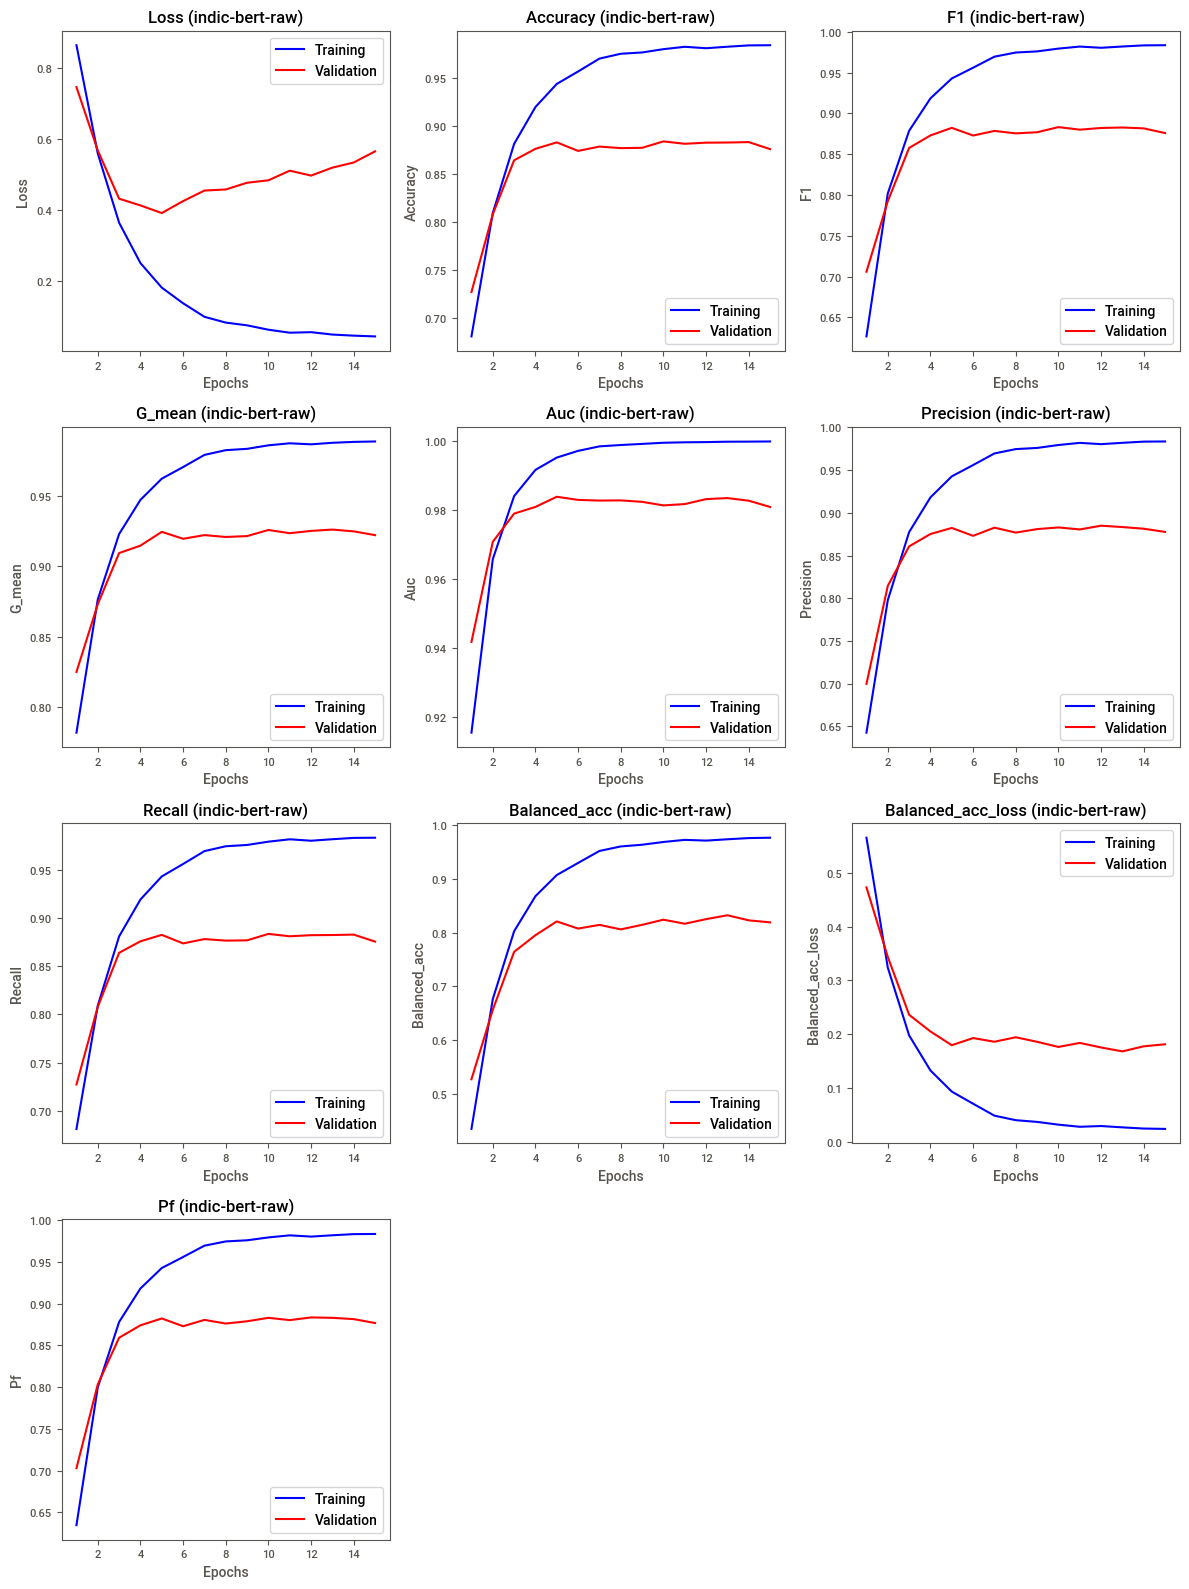

In [ ]:
# plot loss and training curve

plot_metrics_from_checkpoint(
    model_name='indic-bert-raw',
    metrics_to_plot=['loss', 'accuracy', 'f1', 'g_mean', 'auc', 'precision', 'recall', 'balanced_acc', 'balanced_acc_loss', 'pf']
)

#### Raw data using BanglaBERT's Normalizer

In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-r0maj5vj
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-r0maj5vj
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6860 sha256=8b41b04a12e2bee78e73586dd3caa594c3182bc605220749f43a1ca62d1e976c
  Stored in directory: /tmp/pip-ephem-wheel-cache-8afahma_/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186455 sha256=91b06b62fff4bd4cf3c8996b42a4ec8df674872

In [ ]:
# raw-normalized data

from normalizer import normalize

test_model(
    X_train.apply(normalize),
    X_test.apply(normalize),
    y_train,
    y_test,
    indic_bert,
    indic_bert_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='indic-bert-raw-norm')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Model will be trained on: cuda
Starting from scratch...

------ Epoch 1/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.38it/s]


Train Loss: 0.996 | Val Loss: 0.753 | Train Acc: 0.640 | Val Acc: 0.717

------ Epoch 2/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.30it/s]


Train Loss: 0.645 | Val Loss: 0.574 | Train Acc: 0.765 | Val Acc: 0.803

------ Epoch 3/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.50it/s]


Train Loss: 0.422 | Val Loss: 0.459 | Train Acc: 0.860 | Val Acc: 0.847

------ Epoch 4/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.91it/s]


Train Loss: 0.287 | Val Loss: 0.422 | Train Acc: 0.909 | Val Acc: 0.865

------ Epoch 5/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.48it/s]


Train Loss: 0.208 | Val Loss: 0.446 | Train Acc: 0.936 | Val Acc: 0.861

------ Epoch 6/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.46it/s]


Train Loss: 0.149 | Val Loss: 0.436 | Train Acc: 0.956 | Val Acc: 0.872

------ Epoch 7/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.41it/s]


Train Loss: 0.120 | Val Loss: 0.431 | Train Acc: 0.964 | Val Acc: 0.881

------ Epoch 8/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.39it/s]


Train Loss: 0.094 | Val Loss: 0.453 | Train Acc: 0.972 | Val Acc: 0.879

------ Epoch 9/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.33it/s]


Train Loss: 0.078 | Val Loss: 0.487 | Train Acc: 0.976 | Val Acc: 0.881

------ Epoch 10/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.43it/s]


Train Loss: 0.080 | Val Loss: 0.499 | Train Acc: 0.973 | Val Acc: 0.871

------ Epoch 11/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.37it/s]


Train Loss: 0.057 | Val Loss: 0.508 | Train Acc: 0.981 | Val Acc: 0.876

------ Epoch 12/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.41it/s]


Train Loss: 0.061 | Val Loss: 0.496 | Train Acc: 0.980 | Val Acc: 0.882

------ Epoch 13/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.31it/s]


Train Loss: 0.058 | Val Loss: 0.514 | Train Acc: 0.980 | Val Acc: 0.880

------ Epoch 14/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.45it/s]


Train Loss: 0.051 | Val Loss: 0.555 | Train Acc: 0.982 | Val Acc: 0.871

------ Epoch 15/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 17.39it/s]


Train Loss: 0.052 | Val Loss: 0.595 | Train Acc: 0.981 | Val Acc: 0.867

Training & Validation completed. Total time: 44.38 minutes.

Training Metrics:
  Loss: 0.052
  Accuracy: 0.981
  F1: 0.981
  G_mean: 0.987
  Auc: 1.000
  Precision: 0.981
  Recall: 0.981
  Balanced_acc: 0.972
  Balanced_acc_loss: 0.028
  Pf: 0.981

Validation Metrics:
  Loss: 0.595
  Accuracy: 0.867
  F1: 0.868
  G_mean: 0.917
  Auc: 0.980
  Precision: 0.879
  Recall: 0.867
  Balanced_acc: 0.812
  Balanced_acc_loss: 0.188
  Pf: 0.874

------ Best model saved !


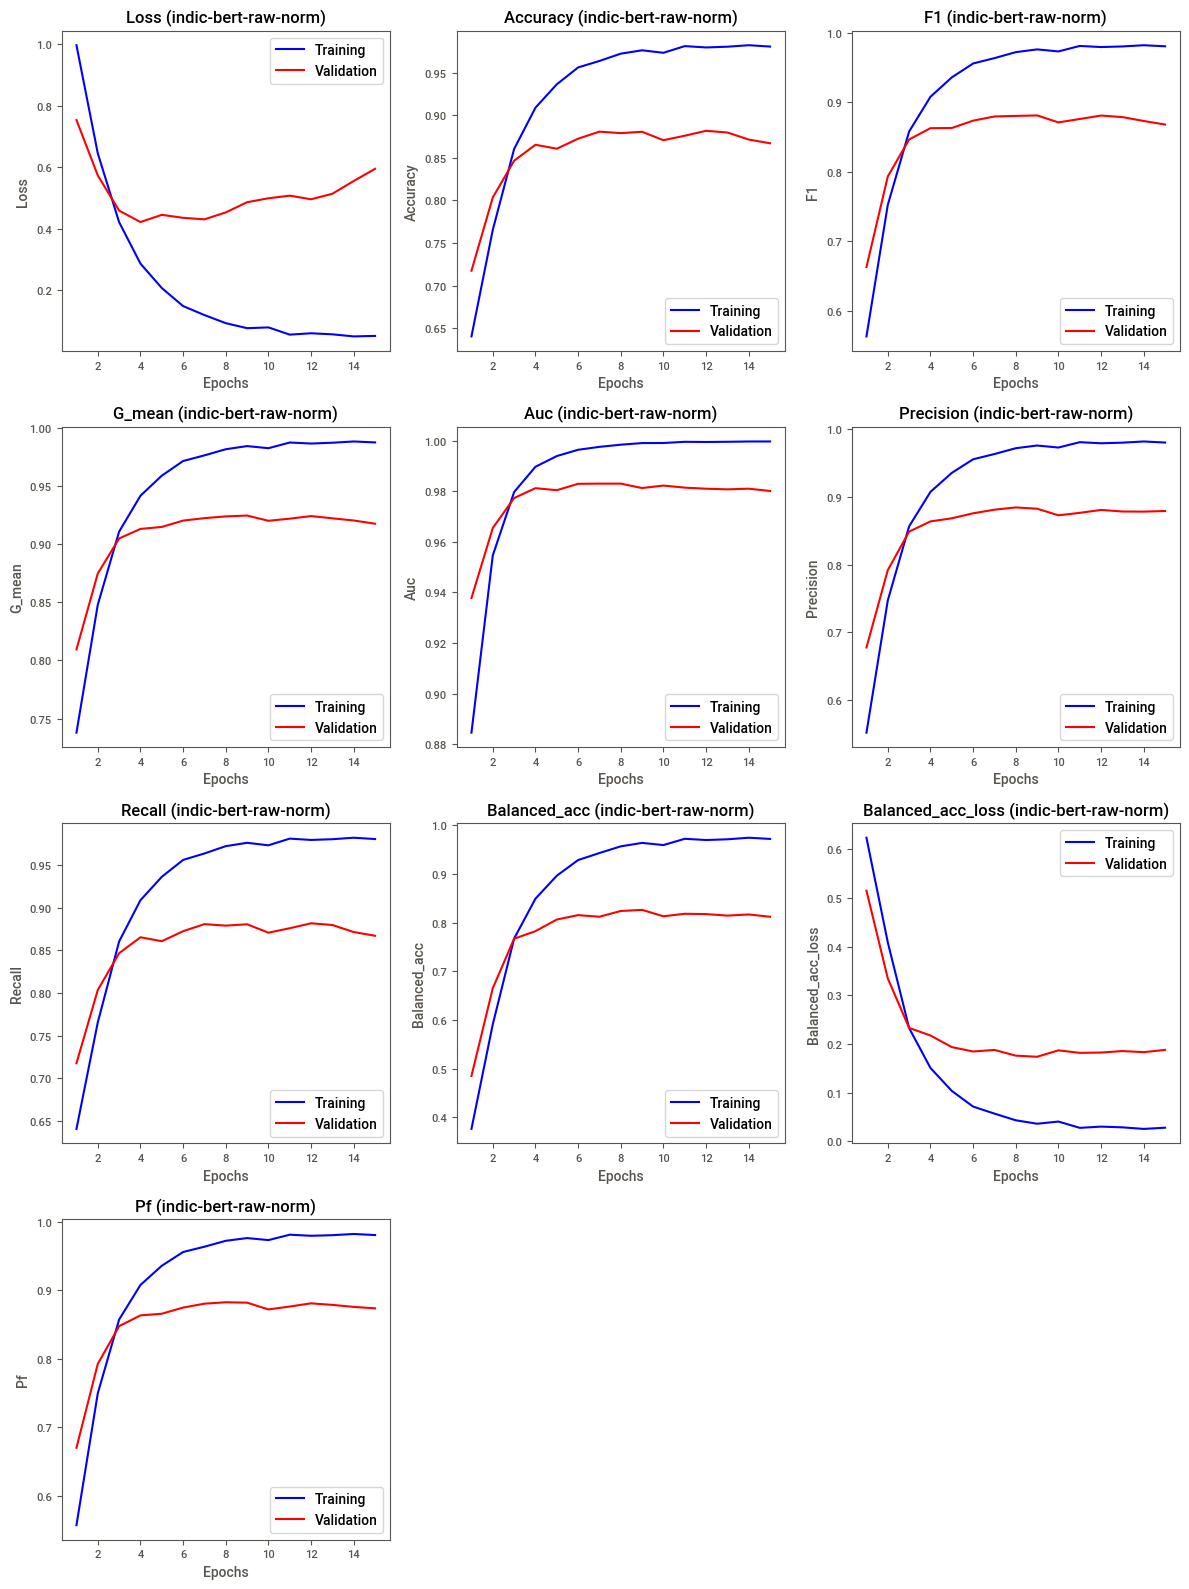

In [ ]:
# plot loss and training curve

plot_metrics_from_checkpoint(
    model_name='indic-bert-raw-norm',
    metrics_to_plot=['loss', 'accuracy', 'f1', 'g_mean', 'auc', 'precision', 'recall', 'balanced_acc', 'balanced_acc_loss', 'pf']
)

#### Using class weights

- lr (1e-5) - 98/88

- Try hyperparametertuning

- lr scheduler, weight decay, batch size

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# raw data using class_weights

indic_bert_raw = test_model(
    X_train,
    X_test,
    y_train,
    y_test,
    indic_bert,
    indic_bert_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='indic-bert-raw-weights',
    class_weights=class_weights
)


Model will be trained on: cuda
Starting from scratch...

------ Epoch 1/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.23it/s]


Train Loss: 0.824 | Val Loss: 0.806 | Train Acc: 0.788 | Val Acc: 0.754

------ Epoch 2/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.23it/s]


Train Loss: 0.541 | Val Loss: 0.585 | Train Acc: 0.847 | Val Acc: 0.842

------ Epoch 3/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.25it/s]


Train Loss: 0.375 | Val Loss: 0.528 | Train Acc: 0.892 | Val Acc: 0.860

------ Epoch 4/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.19it/s]


Train Loss: 0.280 | Val Loss: 0.550 | Train Acc: 0.917 | Val Acc: 0.850

------ Epoch 5/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.26it/s]


Train Loss: 0.201 | Val Loss: 0.555 | Train Acc: 0.939 | Val Acc: 0.852

------ Epoch 6/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.19it/s]


Train Loss: 0.154 | Val Loss: 0.572 | Train Acc: 0.953 | Val Acc: 0.864

------ Epoch 7/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.21it/s]


Train Loss: 0.117 | Val Loss: 0.638 | Train Acc: 0.963 | Val Acc: 0.872

------ Epoch 8/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.19it/s]


Train Loss: 0.109 | Val Loss: 0.630 | Train Acc: 0.967 | Val Acc: 0.860

------ Epoch 9/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.26it/s]


Train Loss: 0.085 | Val Loss: 0.664 | Train Acc: 0.975 | Val Acc: 0.865

------ Epoch 10/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.21it/s]


Train Loss: 0.082 | Val Loss: 0.784 | Train Acc: 0.974 | Val Acc: 0.875

------ Epoch 11/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.26it/s]


Train Loss: 0.070 | Val Loss: 0.689 | Train Acc: 0.977 | Val Acc: 0.869

------ Epoch 12/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.23it/s]


Train Loss: 0.058 | Val Loss: 0.777 | Train Acc: 0.982 | Val Acc: 0.877

------ Epoch 13/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.20it/s]


Train Loss: 0.059 | Val Loss: 0.757 | Train Acc: 0.981 | Val Acc: 0.868

------ Epoch 14/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.26it/s]


Train Loss: 0.066 | Val Loss: 0.723 | Train Acc: 0.980 | Val Acc: 0.876

------ Epoch 15/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.28it/s]


Train Loss: 0.058 | Val Loss: 0.787 | Train Acc: 0.982 | Val Acc: 0.875

Training & Validation completed. Total time: 46.88 minutes.

Training Metrics:
  Loss: 0.058
  Accuracy: 0.982
  F1: 0.982
  G_mean: 0.989
  Auc: 0.999
  Precision: 0.982
  Recall: 0.982
  Balanced_acc: 0.981
  Balanced_acc_loss: 0.019
  Pf: 0.982

Validation Metrics:
  Loss: 0.787
  Accuracy: 0.875
  F1: 0.875
  G_mean: 0.919
  Auc: 0.981
  Precision: 0.876
  Recall: 0.875
  Balanced_acc: 0.821
  Balanced_acc_loss: 0.179
  Pf: 0.876


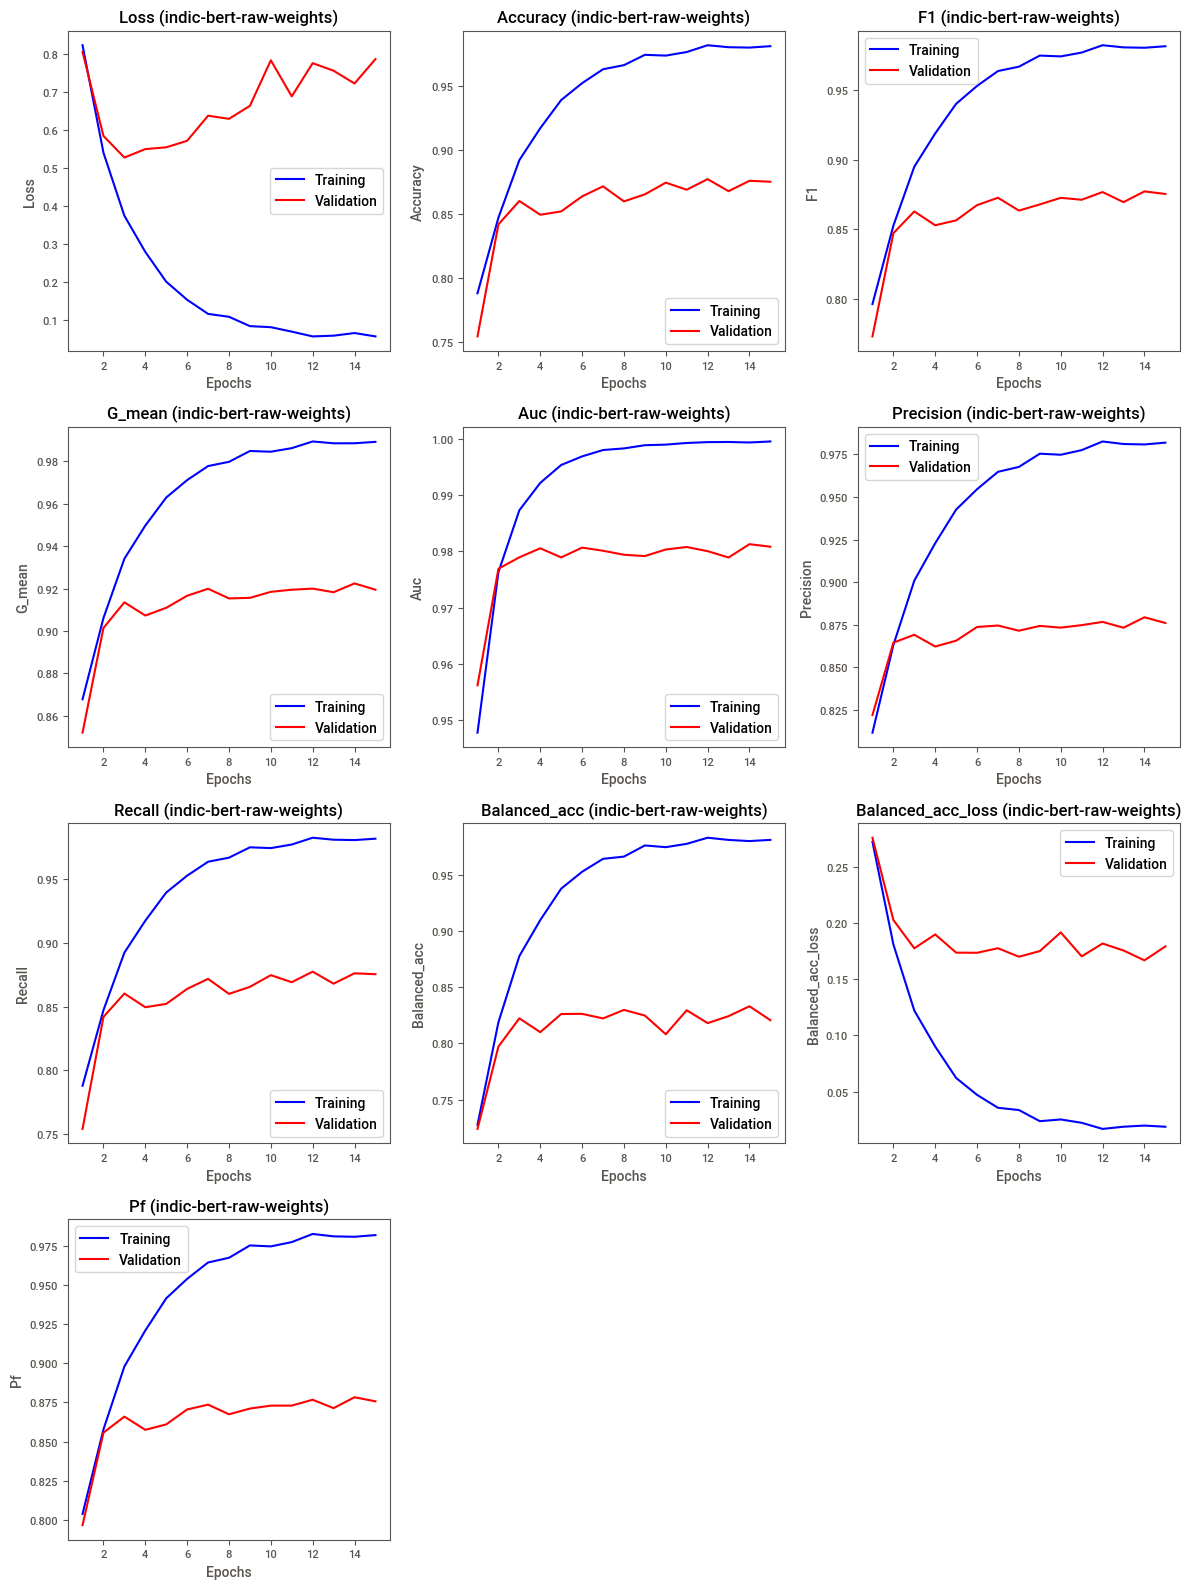

In [ ]:
# plot loss and training curve

plot_metrics_from_checkpoint(
    model_name='indic-bert-raw-weights',
    metrics_to_plot=['loss', 'accuracy', 'f1', 'g_mean', 'auc', 'precision', 'recall', 'balanced_acc', 'balanced_acc_loss', 'pf']
)

#### Sampling (RandomOverSampler)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Oversample minority classes
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
X_train_resampled = X_train_resampled.ravel()  # Flatten back to 1D array


test_model(
    X_train_resampled,
    X_test,
    y_train,
    y_test,
    indic_bert,
    indic_bert_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='indic-bert-ros',
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Model will be trained on: cuda
Starting from scratch...

------ Epoch 1/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.48it/s]


Train Loss: 1.002 | Val Loss: 0.741 | Train Acc: 0.642 | Val Acc: 0.749

------ Epoch 2/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.40it/s]


Train Loss: 0.598 | Val Loss: 0.492 | Train Acc: 0.797 | Val Acc: 0.839

------ Epoch 3/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.41it/s]


Train Loss: 0.379 | Val Loss: 0.410 | Train Acc: 0.875 | Val Acc: 0.864

------ Epoch 4/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.45it/s]


Train Loss: 0.262 | Val Loss: 0.381 | Train Acc: 0.917 | Val Acc: 0.879

------ Epoch 5/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.50it/s]


Train Loss: 0.187 | Val Loss: 0.392 | Train Acc: 0.940 | Val Acc: 0.875

------ Epoch 6/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.49it/s]


Train Loss: 0.135 | Val Loss: 0.420 | Train Acc: 0.958 | Val Acc: 0.877

------ Epoch 7/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.47it/s]


Train Loss: 0.109 | Val Loss: 0.458 | Train Acc: 0.965 | Val Acc: 0.871

------ Epoch 8/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.43it/s]


Train Loss: 0.086 | Val Loss: 0.472 | Train Acc: 0.974 | Val Acc: 0.875

------ Epoch 9/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 15.82it/s]


Train Loss: 0.069 | Val Loss: 0.459 | Train Acc: 0.978 | Val Acc: 0.877

------ Epoch 10/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.47it/s]


Train Loss: 0.061 | Val Loss: 0.492 | Train Acc: 0.981 | Val Acc: 0.876

------ Epoch 11/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.40it/s]


Train Loss: 0.058 | Val Loss: 0.511 | Train Acc: 0.980 | Val Acc: 0.874

------ Epoch 12/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.46it/s]


Train Loss: 0.053 | Val Loss: 0.492 | Train Acc: 0.982 | Val Acc: 0.882

------ Epoch 13/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.34it/s]


Train Loss: 0.052 | Val Loss: 0.562 | Train Acc: 0.982 | Val Acc: 0.867

------ Epoch 14/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.45it/s]


Train Loss: 0.047 | Val Loss: 0.493 | Train Acc: 0.983 | Val Acc: 0.882

------ Epoch 15/15


Evaluating: 100%|██████████| 216/216 [00:13<00:00, 16.45it/s]


Train Loss: 0.043 | Val Loss: 0.502 | Train Acc: 0.984 | Val Acc: 0.882

Training & Validation completed. Total time: 45.01 minutes.

Training Metrics:
  Loss: 0.043
  Accuracy: 0.984
  F1: 0.984
  G_mean: 0.989
  Auc: 1.000
  Precision: 0.984
  Recall: 0.984
  Balanced_acc: 0.977
  Balanced_acc_loss: 0.023
  Pf: 0.984

Validation Metrics:
  Loss: 0.502
  Accuracy: 0.882
  F1: 0.882
  G_mean: 0.926
  Auc: 0.983
  Precision: 0.883
  Recall: 0.882
  Balanced_acc: 0.831
  Balanced_acc_loss: 0.169
  Pf: 0.883


#### Focal loss with class weights (alpha value)



> references :
1. [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)
2. [What is Focal Loss and How to use it - PyTorch Implementation (Binary class)](https://amaarora.github.io/posts/2020-06-29-FocalLoss.html)

            


In [ ]:
# test purpose - not being used

class WeightedFocalLoss(torch.nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = torch.nn.functional.cross_entropy(input, target, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss


In [24]:
# on raw data

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
normalized_class_weights = class_weights / class_weights.sum()
weights = torch.tensor(normalized_class_weights, dtype=torch.float).to(device)

test_model(
    X_train,
    X_test,
    y_train,
    y_test,
    indic_bert,
    indic_bert_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='indic-bert-focal-loss',
    criterion=FocalLoss(gamma=2, alpha=weights, size_average=True)
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Model will be trained on: cuda
Starting from scratch...

------ Epoch 1/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.03it/s]


Train Loss: 0.099 | Val Loss: 0.063 | Train Acc: 0.604 | Val Acc: 0.745

------ Epoch 2/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.00it/s]


Train Loss: 0.045 | Val Loss: 0.041 | Train Acc: 0.780 | Val Acc: 0.830

------ Epoch 3/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.06it/s]


Train Loss: 0.028 | Val Loss: 0.033 | Train Acc: 0.848 | Val Acc: 0.834

------ Epoch 4/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 14.85it/s]


Train Loss: 0.019 | Val Loss: 0.038 | Train Acc: 0.887 | Val Acc: 0.836

------ Epoch 5/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.06it/s]


Train Loss: 0.014 | Val Loss: 0.033 | Train Acc: 0.914 | Val Acc: 0.847

------ Epoch 6/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 14.61it/s]


Train Loss: 0.009 | Val Loss: 0.035 | Train Acc: 0.936 | Val Acc: 0.845

------ Epoch 7/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.06it/s]


Train Loss: 0.007 | Val Loss: 0.036 | Train Acc: 0.950 | Val Acc: 0.868

------ Epoch 8/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.05it/s]


Train Loss: 0.005 | Val Loss: 0.039 | Train Acc: 0.960 | Val Acc: 0.852

------ Epoch 9/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.04it/s]


Train Loss: 0.005 | Val Loss: 0.039 | Train Acc: 0.966 | Val Acc: 0.879

------ Epoch 10/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 14.86it/s]


Train Loss: 0.004 | Val Loss: 0.038 | Train Acc: 0.971 | Val Acc: 0.843

------ Epoch 11/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.04it/s]


Train Loss: 0.003 | Val Loss: 0.040 | Train Acc: 0.975 | Val Acc: 0.855

------ Epoch 12/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.00it/s]


Train Loss: 0.003 | Val Loss: 0.043 | Train Acc: 0.975 | Val Acc: 0.877

------ Epoch 13/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.05it/s]


Train Loss: 0.003 | Val Loss: 0.047 | Train Acc: 0.977 | Val Acc: 0.847

------ Epoch 14/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.03it/s]


Train Loss: 0.003 | Val Loss: 0.040 | Train Acc: 0.977 | Val Acc: 0.875

------ Epoch 15/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.07it/s]


Train Loss: 0.002 | Val Loss: 0.046 | Train Acc: 0.980 | Val Acc: 0.879

Training & Validation completed. Total time: 47.37 minutes.

Training Metrics:
  Loss: 0.002
  Accuracy: 0.980
  F1: 0.981
  G_mean: 0.988
  Auc: 0.999
  Precision: 0.981
  Recall: 0.980
  Balanced_acc: 0.981
  Balanced_acc_loss: 0.019
  Pf: 0.981

Validation Metrics:
  Loss: 0.046
  Accuracy: 0.879
  F1: 0.878
  G_mean: 0.923
  Auc: 0.982
  Precision: 0.882
  Recall: 0.879
  Balanced_acc: 0.824
  Balanced_acc_loss: 0.176
  Pf: 0.880


#### Focal loss with class weights (alpha value) with Sampling

In [25]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

# Oversample minority classes
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
X_train_res = X_train_res.ravel()  # Flatten back to 1D array

# from collections import Counter

# print(f"Original y_train {Counter(y_train)} \n Resampled y_train {Counter(y_train_res)}")
# counter(X_train_res)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
normalized_class_weights = class_weights / class_weights.sum()
weights = torch.tensor(normalized_class_weights, dtype=torch.float).to(device)

In [ ]:
# On randomly over sampled data

test_model(
    X_train_res,
    X_test,
    y_train_res,
    y_test,
    indic_bert,
    indic_bert_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='indic-bert-ros-focal-loss',
    criterion=FocalLoss(gamma=2, alpha=weights, size_average=True)
)

Model will be trained on: cuda
Starting from scratch...

------ Epoch 1/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.07it/s]


Train Loss: 0.002 | Val Loss: 0.045 | Train Acc: 0.985 | Val Acc: 0.880

------ Epoch 2/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 14.95it/s]


Train Loss: 0.002 | Val Loss: 0.048 | Train Acc: 0.986 | Val Acc: 0.879

------ Epoch 3/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 14.99it/s]


Train Loss: 0.001 | Val Loss: 0.051 | Train Acc: 0.989 | Val Acc: 0.879

------ Epoch 4/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.00it/s]


Train Loss: 0.002 | Val Loss: 0.042 | Train Acc: 0.985 | Val Acc: 0.883

------ Epoch 5/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.02it/s]


Train Loss: 0.001 | Val Loss: 0.041 | Train Acc: 0.988 | Val Acc: 0.877

------ Epoch 6/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.04it/s]


Train Loss: 0.001 | Val Loss: 0.045 | Train Acc: 0.990 | Val Acc: 0.883

------ Epoch 7/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.05it/s]


Train Loss: 0.002 | Val Loss: 0.048 | Train Acc: 0.988 | Val Acc: 0.882

------ Epoch 8/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.00it/s]


Train Loss: 0.001 | Val Loss: 0.042 | Train Acc: 0.989 | Val Acc: 0.874

------ Epoch 9/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.00it/s]


Train Loss: 0.001 | Val Loss: 0.046 | Train Acc: 0.989 | Val Acc: 0.882

------ Epoch 10/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.01it/s]


Train Loss: 0.001 | Val Loss: 0.044 | Train Acc: 0.990 | Val Acc: 0.891

------ Epoch 11/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 14.99it/s]


Train Loss: 0.001 | Val Loss: 0.045 | Train Acc: 0.989 | Val Acc: 0.891

------ Epoch 12/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.02it/s]


Train Loss: 0.001 | Val Loss: 0.042 | Train Acc: 0.990 | Val Acc: 0.882

------ Epoch 13/15


Evaluating: 100%|██████████| 216/216 [00:14<00:00, 15.02it/s]


Train Loss: 0.001 | Val Loss: 0.044 | Train Acc: 0.989 | Val Acc: 0.893

------ Epoch 14/15


Training:  44%|████▍     | 975/2197 [03:17<04:08,  4.91it/s]

## Distil-BERT-Multilingual

- Raw data - 97%/90%

- Raw normalized data - 97%/95% (Recheck)

In [ ]:
# Distil-BERT-Multilingual
from transformers import AutoModelForSequenceClassification, AutoTokenizer

distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')
distilbert = AutoModelForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=6)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# raw data

distill_bert_raw = test_model(
    X_train,
    X_test,
    y_train,
    y_test,
    distilbert,
    distilbert_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='distilbert-raw')

Model will be trained on: cuda
Starting from scratch...

------ Epoch 1/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.16it/s]


Train Loss: 0.803 | Val Loss: 0.486 | Train Acc: 0.724 | Val Acc: 0.834
Best model saved at epoch 1 with Val Acc: 0.834

------ Epoch 2/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.15it/s]


Train Loss: 0.417 | Val Loss: 0.389 | Train Acc: 0.862 | Val Acc: 0.873
Best model saved at epoch 2 with Val Acc: 0.873

------ Epoch 3/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.12it/s]


Train Loss: 0.307 | Val Loss: 0.315 | Train Acc: 0.899 | Val Acc: 0.894
Best model saved at epoch 3 with Val Acc: 0.894

------ Epoch 4/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.22it/s]


Train Loss: 0.250 | Val Loss: 0.307 | Train Acc: 0.916 | Val Acc: 0.902
Best model saved at epoch 4 with Val Acc: 0.902

------ Epoch 5/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.02it/s]


Train Loss: 0.204 | Val Loss: 0.306 | Train Acc: 0.931 | Val Acc: 0.905
Best model saved at epoch 5 with Val Acc: 0.905

------ Epoch 6/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 19.99it/s]


Train Loss: 0.176 | Val Loss: 0.319 | Train Acc: 0.940 | Val Acc: 0.905

------ Epoch 7/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.17it/s]


Train Loss: 0.150 | Val Loss: 0.351 | Train Acc: 0.949 | Val Acc: 0.898

------ Epoch 8/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.03it/s]


Train Loss: 0.128 | Val Loss: 0.333 | Train Acc: 0.955 | Val Acc: 0.907
Best model saved at epoch 8 with Val Acc: 0.907

------ Epoch 9/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.06it/s]


Train Loss: 0.114 | Val Loss: 0.334 | Train Acc: 0.960 | Val Acc: 0.906

------ Epoch 10/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.20it/s]


Train Loss: 0.102 | Val Loss: 0.347 | Train Acc: 0.963 | Val Acc: 0.907

------ Epoch 11/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 19.99it/s]


Train Loss: 0.090 | Val Loss: 0.357 | Train Acc: 0.969 | Val Acc: 0.905

------ Epoch 12/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.01it/s]


Train Loss: 0.084 | Val Loss: 0.372 | Train Acc: 0.969 | Val Acc: 0.907

------ Epoch 13/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.00it/s]


Train Loss: 0.080 | Val Loss: 0.395 | Train Acc: 0.971 | Val Acc: 0.906

------ Epoch 14/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.03it/s]


Train Loss: 0.073 | Val Loss: 0.379 | Train Acc: 0.974 | Val Acc: 0.909
Best model saved at epoch 14 with Val Acc: 0.909

------ Epoch 15/15


Evaluating: 100%|██████████| 216/216 [00:10<00:00, 20.02it/s]


Train Loss: 0.068 | Val Loss: 0.397 | Train Acc: 0.974 | Val Acc: 0.906

Training & Validation completed. Total time: 49.81 minutes.

Training Metrics:
  Loss: 0.068
  Accuracy: 0.974
  F1: 0.974
  G_mean: 0.983
  Auc: 0.999
  Precision: 0.974
  Recall: 0.974
  Balanced_acc: 0.962
  Balanced_acc_loss: 0.038
  Pf: 0.974

Validation Metrics:
  Loss: 0.397
  Accuracy: 0.906
  F1: 0.905
  G_mean: 0.937
  Auc: 0.987
  Precision: 0.905
  Recall: 0.906
  Balanced_acc: 0.858
  Balanced_acc_loss: 0.142
  Pf: 0.905

------ Best model saved !


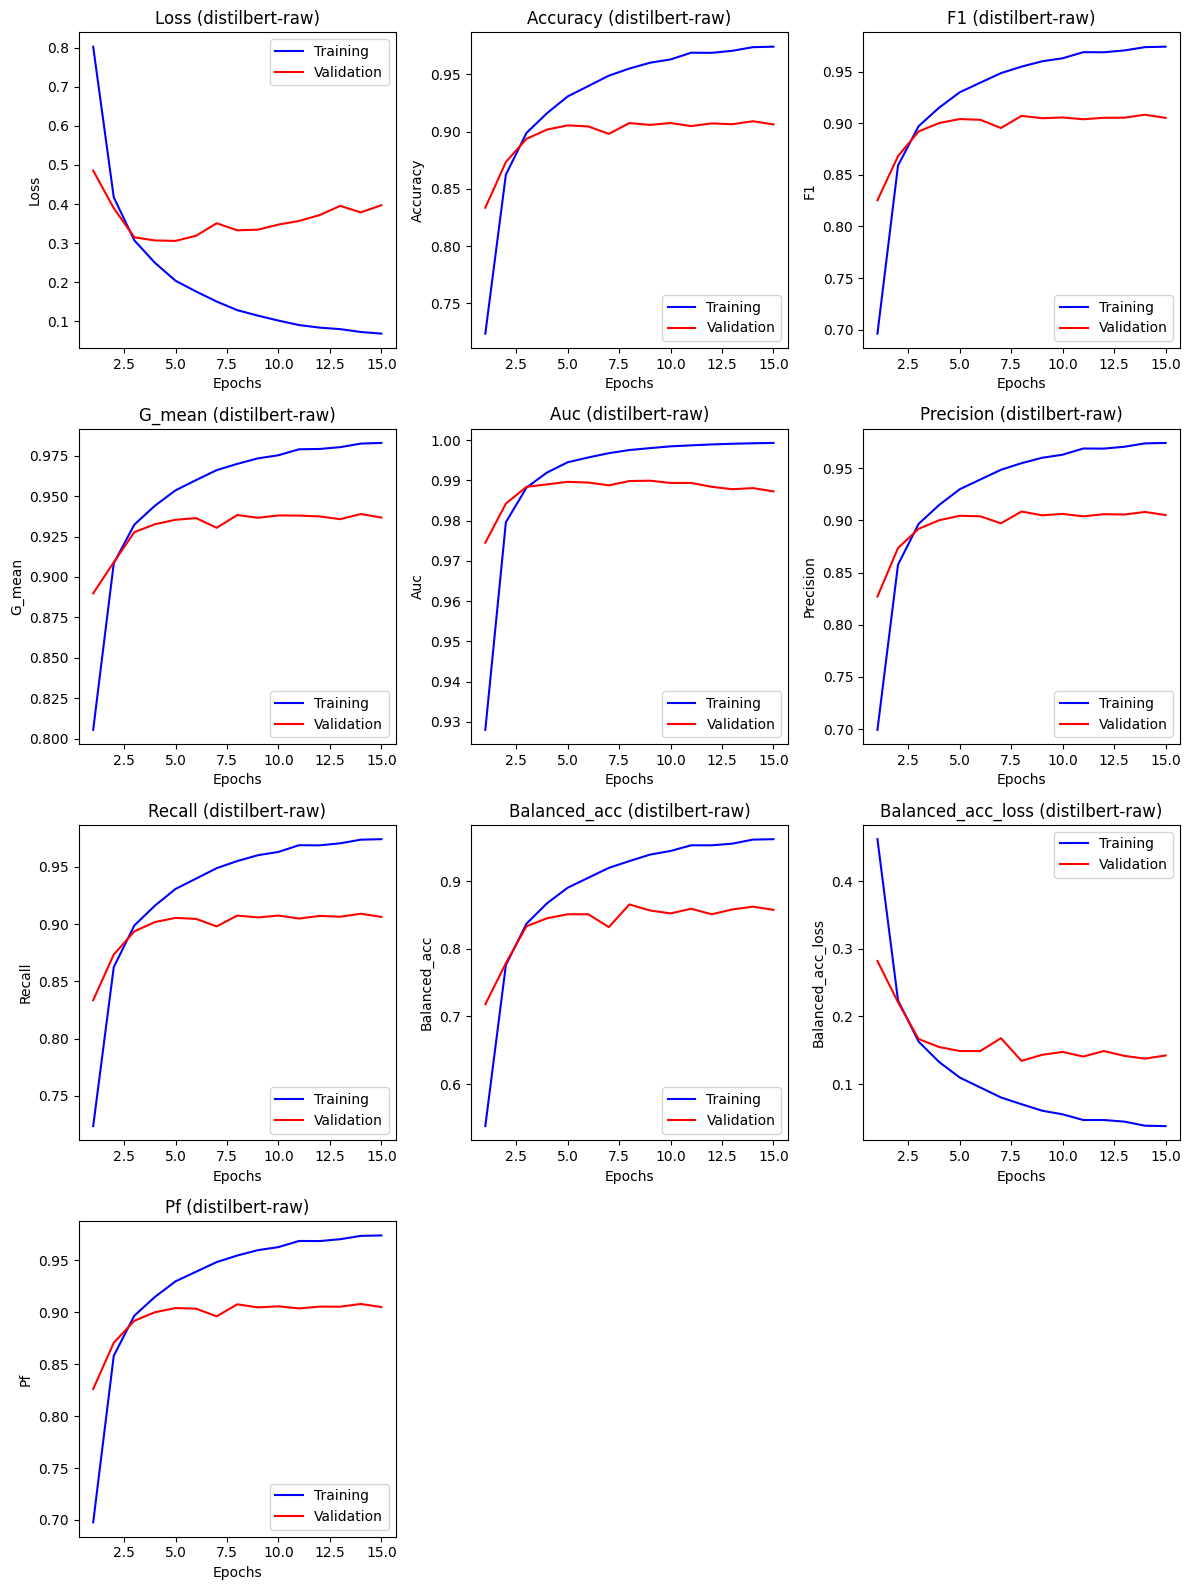

In [ ]:
# plot loss and training curve

plot_metrics_from_checkpoint(
    model_name='distilbert-raw',
    metrics_to_plot=['loss', 'accuracy', 'f1', 'g_mean', 'auc', 'precision', 'recall', 'balanced_acc', 'balanced_acc_loss', 'pf']
)

In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-mhu3rac3
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-mhu3rac3
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6860 sha256=ccd20805a9ebdd388b2480443355589833c6f120c5d05892f22894dbe4b079d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-kxpm25oy/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186455 sha256=7f12aee872a99e990ddefe45fb5f10b477bff16

In [ ]:
# raw-normalized data

from normalizer import normalize

distill_bert_raw = test_model(
    X_train.apply(normalize),
    X_test.apply(normalize),
    y_train,
    y_test,
    distilbert,
    distilbert_tokenizer,
    epochs=15,
    batch_size=32,
    model_name='distilbert-raw-norm')

Model will be trained on: cuda
Checkpoint loaded. Resuming from epoch 9. Total time so far: 27.74 minutes.

------ Epoch 9/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.72it/s]


Train Loss: 0.129 | Val Loss: 0.108 | Train Acc: 0.959 | Val Acc: 0.965

Best model saved at epoch 9 with Val Acc: 0.965

------ Epoch 10/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.78it/s]


Train Loss: 0.106 | Val Loss: 0.115 | Train Acc: 0.964 | Val Acc: 0.964

------ Epoch 11/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.82it/s]


Train Loss: 0.089 | Val Loss: 0.132 | Train Acc: 0.971 | Val Acc: 0.960

------ Epoch 12/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.90it/s]


Train Loss: 0.082 | Val Loss: 0.130 | Train Acc: 0.972 | Val Acc: 0.959

------ Epoch 13/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.82it/s]


Train Loss: 0.069 | Val Loss: 0.148 | Train Acc: 0.975 | Val Acc: 0.959

------ Epoch 14/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.83it/s]


Train Loss: 0.068 | Val Loss: 0.154 | Train Acc: 0.976 | Val Acc: 0.956

------ Epoch 15/15


Evaluating: 100%|██████████| 216/216 [00:12<00:00, 16.91it/s]


Train Loss: 0.058 | Val Loss: 0.157 | Train Acc: 0.979 | Val Acc: 0.957

Training & Validation completed. Total time: 51.30 minutes.

Training Metrics:
  Loss: 0.058
  Accuracy: 0.979
  F1: 0.979
  G_mean: 0.986
  Auc: 0.999
  Precision: 0.979
  Recall: 0.979
  Balanced_acc: 0.970
  Balanced_acc_loss: 0.030
  Pf: 0.979

Validation Metrics:
  Loss: 0.157
  Accuracy: 0.957
  F1: 0.957
  G_mean: 0.971
  Auc: 0.997
  Precision: 0.957
  Recall: 0.957
  Balanced_acc: 0.936
  Balanced_acc_loss: 0.064
  Pf: 0.957

------ Best model saved !


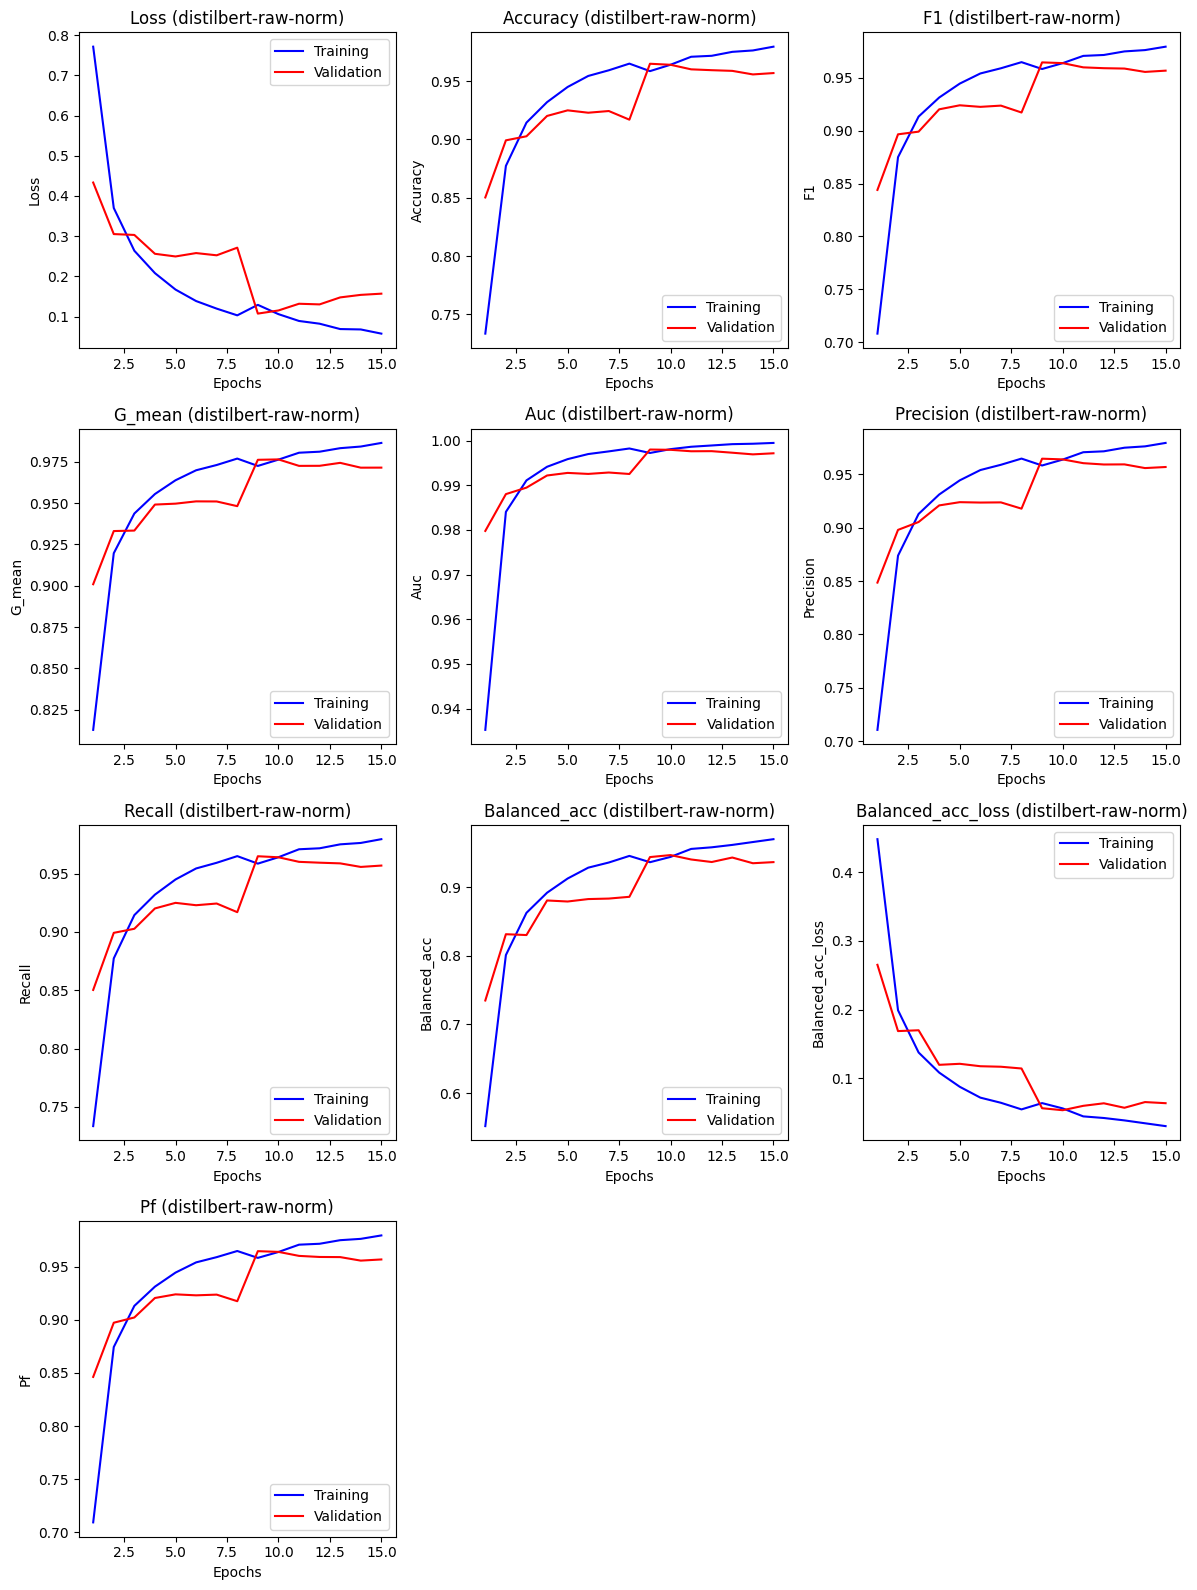

In [ ]:
# plot loss and training curve

plot_metrics_from_checkpoint(
    model_name='distilbert-raw-norm',
    metrics_to_plot=['loss', 'accuracy', 'f1', 'g_mean', 'auc', 'precision', 'recall', 'balanced_acc', 'balanced_acc_loss', 'pf']
)